https://jcollopy-tulane.github.io

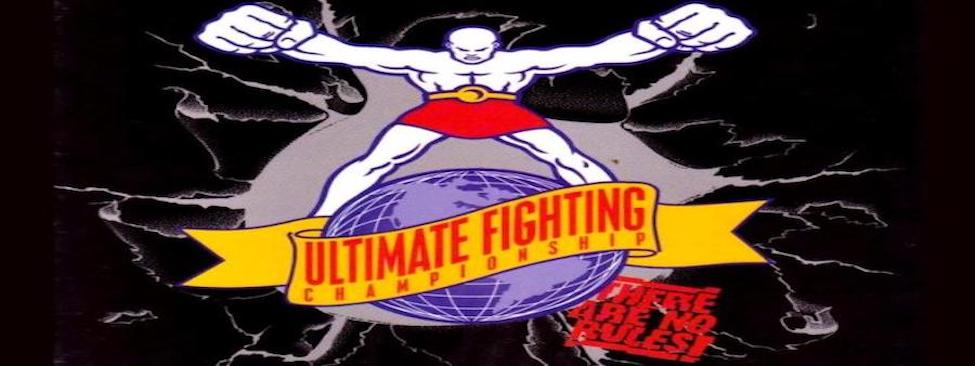

# Exploring Decision Fights in the UFC
## -- John Collopy

### Links to Each Section

1. [Introduction](#Introduction)
2. [Further Reading](#Further-Reading)
3. [ETL](#ETL)
4. [EDA](#EDA)
5. [Model Selection](#Model-Selection)

# Motivation

I find Mixed Martial Arts compelling due to the unpredicable nature of a fight. Danger is always imminent, and an exciting ending is always on the table. That being said, a large number of fights do not end in a decisive knockout or submission, and so three judges are left to decide who won the fight. The three judges are supposed to judge the fight according to the [Unified Rules of Mixed Arts](https://www.abcboxing.com/wp-content/uploads/2020/02/unified-rules-mma-2019.pdf). 

Judges assess the fight largely according to three criteria: 

- Effective striking/grappling 
- Effective aggressiveness
- Control of the fighting area 

However, this language is subjective and leaves room for interpretation. Hence, it is important to ask what we can learn from fight data regarding distinguishing between a winner and a loser. This project will use logistic regression so as to predict the result of a fight. Inspecting the model will allow us to better understand what features are most valuable to judges when they are scoring a fight. This analysis could be particularly useful to athletes and coaches, as a better understanding of the criteria by which they are being judged might allow them to develop a more effective strategy in competition.

# Further Reading

For those interested in learning more about the judging criteria, controversial decisions, or the frustrated athletes, a few links are provided below.

 - [Quick and Easy Guide to MMA Judging Criteria](https://news.bet365.com/en-gb/article/ufc-fight-scoring-system-and-decisions-explained/2023022017090311259)
 - [Controversial Decisions in UFC History](https://bleacherreport.com/articles/2072171-the-10-most-controversial-judging-decisions-in-ufc-history)
 - [Athlete Upset With Judges](https://www.mmafighting.com/2023/6/6/23750061/kai-kara-france-rips-judges-after-controversial-ufc-vegas-74-decision-that-cost-me-100000)

# ETL 

The data used for this project comes from [ufcstats.com](http://www.ufcstats.com/statistics/events/completed?page=all), a website containing data from every UFC fight. This site contains multiple "layers", from which separate datasets were created. The first "layer" of this site contains links that track simple counting statistics for each fight, such as number of knockdowns, significant strikes, takedowns, and submission attempts. This data will assist in the initial EDA, as I will create charts displaying the distibutions of the winner's differentials with respect to these features.. The second "layer" of this site contains more advanced striking metrics about each fight. This data will be merged with the first dataset in order to build a more detailed model that will predict fight results.

In [2]:
# Importing the necessary packages to scrape the data

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import requests
from tqdm import tqdm
import re

In [9]:
# Retrieving the URL that contains links to all fight data

url = "http://www.ufcstats.com/statistics/events/completed?page=all"
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.3 Safari/605.1.15"}


html = requests.get(url, headers = headers)
soup = bs(html.content, "html.parser")

I now have the content for the site, and I will put the link containing data for each fight into a list, which will then be scraped for fight data.

### Scraping the First "Layer" of Data

In [10]:
# Putting each link on the home page into a list

first_layer = []
for link in tqdm(soup.find_all('a', href=True), desc="Scraping First Layer"):
    page = link['href']
    first_layer.append(page)

Scraping First Layer: 100%|███████████████| 692/692 [00:00<00:00, 676406.05it/s]


The data for this analysis will contain fight data starting from the UFC's first event up to and including UFC 294: Makhachev vs. Volkanovski 2, which took place on 10/24/2023.

In [14]:
# Removing all links that do not contain relevant fight data

first_layer = first_layer[9:-16] 

In [15]:
# Extracting Data From the "first layer" of the UFC Stats site and creating a dataframe

main_dataframe = pd.DataFrame()

for url in tqdm(first_layer, desc="Scraping First Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "html.parser")
    table = soup.find("table")
    data = pd.read_html(str(table))
    adj_data = pd.concat(data)
    
    event = soup.find("h2", class_="b-content__title").text.strip()
    

    adj_data["Event"] = event
    
    main_dataframe = pd.concat([main_dataframe, adj_data], ignore_index=True)
    
main_dataframe.head()

Scraping First Layer: 100%|███████████████████| 667/667 [04:26<00:00,  2.50it/s]


,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time,Event
0,win,Islam Makhachev Alexander Volkanovski,1 0,24 4,0 0,0 0,Lightweight,KO/TKO Kick,1,3:06,UFC 294: Makhachev vs. Volkanovski 2
1,win,Khamzat Chimaev Kamaru Usman,0 0,38 36,4 0,1 0,Middleweight,M-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2
2,nc nc,Magomed Ankalaev Johnny Walker,0 0,13 14,1 0,0 0,Light Heavyweight,CNC,1,3:13,UFC 294: Makhachev vs. Volkanovski 2
3,win,Ikram Aliskerov Warlley Alves,1 0,26 12,0 0,0 0,Middleweight,KO/TKO Punches,1,2:07,UFC 294: Makhachev vs. Volkanovski 2
4,win,Said Nurmagomedov Muin Gafurov,0 0,5 1,0 0,1 0,Bantamweight,SUB Guillotine Choke,1,1:13,UFC 294: Makhachev vs. Volkanovski 2


I now have some preliminary data for each fight. The data must be cleaned and requires some feature engineering, but since the data took some time to scrape, I will now save the dataframe as a .csv file, which will be imported later.

In [6]:
main_dataframe.to_csv('ufc_initial_file.csv')

## Scraping the Second Layer of Data (Part 1)

In [ ]:
# Getting the links for each fight

second_layer = []

with tqdm(first_layer, desc="Scraping Links") as layer:
    for link in layer:
        html = requests.get(link, headers = headers)
        soup = bs(html.content, "lxml")
        
        for link in soup.find_all('a', href=True):
            if "fight-details" in link['href']:
                    second_layer.append(link['href'])

In [24]:
main_df_1 = pd.DataFrame()  

for url in tqdm(second_layer[:1000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Sig. str.", "Td", "Rev.", "Ctrl"]].dropna()

    
    combined_table["Event"] = event_name

    main_df_1 = pd.concat([main_df_1, combined_table], ignore_index=True)

main_df_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [11:49<00:00,  1.41it/s]


,Fighter,Sig. str.,Td,Rev.,Ctrl,Event
0,Islam Makhachev Alexander Volkanovski,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00,UFC 294: Makhachev vs. Volkanovski 2


In [26]:
for url in tqdm(second_layer[1000:2000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Sig. str.", "Td", "Rev.", "Ctrl"]].dropna()

    
    combined_table["Event"] = event_name

    main_df_1 = pd.concat([main_df_1, combined_table], ignore_index=True)

main_df_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [11:46<00:00,  1.42it/s]


,Fighter,Sig. str.,Td,Rev.,Ctrl,Event
0,Islam Makhachev Alexander Volkanovski,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00,UFC 294: Makhachev vs. Volkanovski 2


In [28]:
for url in tqdm(second_layer[2000:3000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Sig. str.", "Td", "Rev.", "Ctrl"]].dropna()

    
    combined_table["Event"] = event_name

    main_df_1 = pd.concat([main_df_1, combined_table], ignore_index=True)

main_df_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [12:05<00:00,  1.38it/s]


,Fighter,Sig. str.,Td,Rev.,Ctrl,Event
0,Islam Makhachev Alexander Volkanovski,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00,UFC 294: Makhachev vs. Volkanovski 2


In [30]:
for url in tqdm(second_layer[3000:4000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Sig. str.", "Td", "Rev.", "Ctrl"]].dropna()

    
    combined_table["Event"] = event_name

    main_df_1 = pd.concat([main_df_1, combined_table], ignore_index=True)

main_df_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [12:07<00:00,  1.37it/s]


,Fighter,Sig. str.,Td,Rev.,Ctrl,Event
0,Islam Makhachev Alexander Volkanovski,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00,UFC 294: Makhachev vs. Volkanovski 2


In [32]:
for url in tqdm(second_layer[4000:5000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Sig. str.", "Td", "Rev.", "Ctrl"]].dropna()

    
    combined_table["Event"] = event_name

    main_df_1 = pd.concat([main_df_1, combined_table], ignore_index=True)

main_df_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [12:50<00:00,  1.30it/s]


,Fighter,Sig. str.,Td,Rev.,Ctrl,Event
0,Islam Makhachev Alexander Volkanovski,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00,UFC 294: Makhachev vs. Volkanovski 2


In [34]:
for url in tqdm(second_layer[5000:6000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Sig. str.", "Td", "Rev.", "Ctrl"]].dropna()

    
    combined_table["Event"] = event_name

    main_df_1 = pd.concat([main_df_1, combined_table], ignore_index=True)

main_df_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [11:53<00:00,  1.40it/s]


,Fighter,Sig. str.,Td,Rev.,Ctrl,Event
0,Islam Makhachev Alexander Volkanovski,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00,UFC 294: Makhachev vs. Volkanovski 2


In [36]:
for url in tqdm(second_layer[6000:7340], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Sig. str.", "Td", "Rev.", "Ctrl"]].dropna()

    
    combined_table["Event"] = event_name

    main_df_1 = pd.concat([main_df_1, combined_table], ignore_index=True)

main_df_1.head()

Scraping Second Layer: 100%|████████████████| 1340/1340 [13:18<00:00,  1.68it/s]


,Fighter,Sig. str.,Td,Rev.,Ctrl,Event
0,Islam Makhachev Alexander Volkanovski,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00,UFC 294: Makhachev vs. Volkanovski 2


In [37]:
main_df_1.to_csv("ufc_second_csv")

## Scraping the Second Layer of Data (Part 2)

The second layer of data took a while to scrape, and so I will save this dataset as a .csv file as well, which will be imported later. Also, due to a number of issues scraping all of the data at once, I broke the scraping up into bits to ensure that the code ran to completion.

In [8]:
# Initialize the main DataFrame

main_dataframe_1 = pd.DataFrame()  

for url in tqdm(second_layer[:500], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Head", "Body", "Leg", "Distance", "Clinch", "Ground"]].dropna()

    
    combined_table["Event"] = event_name

    main_dataframe_1 = pd.concat([main_dataframe_1, combined_table], ignore_index=True)

main_dataframe_1.head()

Scraping Second Layer: 100%|██████████████████| 500/500 [05:40<00:00,  1.47it/s]


,Fighter,Ctrl,Td,Head,Body,Leg,Distance,Clinch,Ground,Event


In [10]:
# Scraping the next 1,500 links

for url in tqdm(second_layer[500:2000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Ctrl", "Head", "Body", "Leg", "Distance", "Clinch", "Ground"]].dropna()

    
    combined_table["Event"] = event_name

    main_dataframe_1 = pd.concat([main_dataframe_1, combined_table], ignore_index=True)

main_dataframe_1.head()

Scraping Second Layer: 100%|████████████████| 1500/1500 [19:14<00:00,  1.30it/s]


,Fighter,Head,Body,Leg,Distance,Clinch,Ground,Event
0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2


In [13]:
# Scraping the next 1,000 links

for url in tqdm(second_layer[2000:3000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Head", "Body", "Leg", "Distance", "Clinch", "Ground"]].dropna()

    
    combined_table["Event"] = event_name

    main_dataframe_1 = pd.concat([main_dataframe_1, combined_table], ignore_index=True)

main_dataframe_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [13:36<00:00,  1.22it/s]


,Fighter,Head,Body,Leg,Distance,Clinch,Ground,Event
0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2


In [15]:
# Scraping the next 1,000 links

for url in tqdm(second_layer[3000:4000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Head", "Body", "Leg", "Distance", "Clinch", "Ground"]].dropna()

    
    combined_table["Event"] = event_name

    main_dataframe_1 = pd.concat([main_dataframe_1, combined_table], ignore_index=True)

main_dataframe_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [13:43<00:00,  1.21it/s]


,Fighter,Head,Body,Leg,Distance,Clinch,Ground,Event
0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2


In [18]:
# Scraping the next 1,000 links

for url in tqdm(second_layer[4000:5000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Head", "Body", "Leg", "Distance", "Clinch", "Ground"]].dropna()

    
    combined_table["Event"] = event_name

    main_dataframe_1 = pd.concat([main_dataframe_1, combined_table], ignore_index=True)

main_dataframe_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [13:27<00:00,  1.24it/s]


,Fighter,Head,Body,Leg,Distance,Clinch,Ground,Event
0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2


In [19]:
# Scraping the next 1,000 links

for url in tqdm(second_layer[5000:6000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Head", "Body", "Leg", "Distance", "Clinch", "Ground"]].dropna()

    
    combined_table["Event"] = event_name

    main_dataframe_1 = pd.concat([main_dataframe_1, combined_table], ignore_index=True)

main_dataframe_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [13:35<00:00,  1.23it/s]


,Fighter,Head,Body,Leg,Distance,Clinch,Ground,Event
0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2


In [20]:
# Scraping the rest of the links

for url in tqdm(second_layer[6000:7340], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Head", "Body", "Leg", "Distance", "Clinch", "Ground"]].dropna()

    
    combined_table["Event"] = event_name

    main_dataframe_1 = pd.concat([main_dataframe_1, combined_table], ignore_index=True)

main_dataframe_1.head()

Scraping Second Layer: 100%|████████████████| 1340/1340 [15:49<00:00,  1.41it/s]


,Fighter,Head,Body,Leg,Distance,Clinch,Ground,Event
0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2


In [22]:
main_dataframe_1.to_csv('ufc_compiled.csv')

### Unifying the Datasets

Now, it is time to unify and clean the data. Here are the variables in the initial dataframe:

- Unnamed: 0: Index Column
- W/L: Indicates the outcome of the fight
- Fighter: Contains the names of the fighter (Winning fighter on the left)
- Kd: Number of knockdowns for each fighter (Winning fighter's number on the left)
- Str: Number of significant strikes for each fighter (Winning fighter's number on the left)
- Td: Number of takedowns for each fighter (Winning fighter's number on the left)
- Sub: Number of submission attempts for each fighter (Winning fighter's number on the left)
- Weight class: Weightclass in which the fight took place
- Method: Method of victory
- Round: Round in which the fight ended
- Time: Time at which the fight ended

I will remove unnecessary columns and remove leading and trailing whitespace in the "Fighter" column. I will also check for null values.

In [53]:
data_1 = pd.read_csv("ufc_initial_file.csv")
data_1.head()

,Unnamed: 0,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time,Event
0,0,win,Islam Makhachev Alexander Volkanovski,1 0,24 4,0 0,0 0,Lightweight,KO/TKO Kick,1,3:06,UFC 294: Makhachev vs. Volkanovski 2
1,1,win,Khamzat Chimaev Kamaru Usman,0 0,38 36,4 0,1 0,Middleweight,M-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2
2,2,nc nc,Magomed Ankalaev Johnny Walker,0 0,13 14,1 0,0 0,Light Heavyweight,CNC,1,3:13,UFC 294: Makhachev vs. Volkanovski 2
3,3,win,Ikram Aliskerov Warlley Alves,1 0,26 12,0 0,0 0,Middleweight,KO/TKO Punches,1,2:07,UFC 294: Makhachev vs. Volkanovski 2
4,4,win,Said Nurmagomedov Muin Gafurov,0 0,5 1,0 0,1 0,Bantamweight,SUB Guillotine Choke,1,1:13,UFC 294: Makhachev vs. Volkanovski 2


In [54]:
data_1 = data_1.drop(columns=["Unnamed: 0", "W/L", "Weight class", "Time"], axis=1)
data_1["Fighter"] = data_1["Fighter"].str.strip()
data_1.head()

,Fighter,Kd,Str,Td,Sub,Method,Round,Event
0,Islam Makhachev Alexander Volkanovski,1 0,24 4,0 0,0 0,KO/TKO Kick,1,UFC 294: Makhachev vs. Volkanovski 2
1,Khamzat Chimaev Kamaru Usman,0 0,38 36,4 0,1 0,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,0 0,13 14,1 0,0 0,CNC,1,UFC 294: Makhachev vs. Volkanovski 2
3,Ikram Aliskerov Warlley Alves,1 0,26 12,0 0,0 0,KO/TKO Punches,1,UFC 294: Makhachev vs. Volkanovski 2
4,Said Nurmagomedov Muin Gafurov,0 0,5 1,0 0,1 0,SUB Guillotine Choke,1,UFC 294: Makhachev vs. Volkanovski 2


Now, I will convert the strings in "Kd", "Str", "Td", and "Sub" into lists of numbers. I will change non-numeric items (in this case "--") into 0's.

In [55]:
def convert_to_int(x):
    return [int(i) if isinstance(i, str) and i != '--' else 0 for i in x] if isinstance(x, list) else [0]

data_1["Kd"] = data_1["Kd"].str.split().apply(convert_to_int)
data_1["Str"] = data_1["Str"].str.split().apply(convert_to_int)
data_1["Td"] = data_1["Td"].str.split().apply(convert_to_int)
data_1["Sub"] = data_1["Sub"].str.split().apply(convert_to_int)

data_1

,Fighter,Kd,Str,Td,Sub,Method,Round,Event
0,Islam Makhachev Alexander Volkanovski,"[1, 0]","[24, 4]","[0, 0]","[0, 0]",KO/TKO Kick,1,UFC 294: Makhachev vs. Volkanovski 2
1,Khamzat Chimaev Kamaru Usman,"[0, 0]","[38, 36]","[4, 0]","[1, 0]",M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,"[0, 0]","[13, 14]","[1, 0]","[0, 0]",CNC,1,UFC 294: Makhachev vs. Volkanovski 2
3,Ikram Aliskerov Warlley Alves,"[1, 0]","[26, 12]","[0, 0]","[0, 0]",KO/TKO Punches,1,UFC 294: Makhachev vs. Volkanovski 2
4,Said Nurmagomedov Muin Gafurov,"[0, 0]","[5, 1]","[0, 0]","[1, 0]",SUB Guillotine Choke,1,UFC 294: Makhachev vs. Volkanovski 2
...,...,...,...,...,...,...,...,...
7380,Orlando Wiet Robert Lucarelli,"[0, 0]","[8, 2]","[0, 1]","[0, 1]",KO/TKO,1,UFC 2: No Way Out
7381,Frank Hamaker Thaddeus Luster,"[0, 0]","[2, 0]","[1, 0]","[3, 0]",SUB Keylock,1,UFC 2: No Way Out
7382,Johnny Rhodes David Levicki,"[0, 0]","[11, 4]","[1, 0]","[0, 0]",KO/TKO Punches,1,UFC 2: No Way Out
7383,Patrick Smith Ray Wizard,"[0, 0]","[1, 1]","[0, 0]","[1, 0]",SUB Guillotine Choke,1,UFC 2: No Way Out


The data types are displayed below. Further cleaning will be done after the datasets are merged.

In [56]:
data_1.dtypes

Fighter    object
Kd         object
Str        object
Td         object
Sub        object
Method     object
Round       int64
Event      object
dtype: object

I will now import the second dataset. I remove unnecessary columns and remove leading and trailing whitespace from the "Fighter" column. There are duplicate rows in this dataset, which I also remove.

In [57]:
data_2 = pd.read_csv("ufc_compiled.csv")
data_2.head()

,Unnamed: 0,Fighter,Head,Body,Leg,Distance,Clinch,Ground,Event
0,0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
1,1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2
2,2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
3,3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
4,4,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2


In [58]:
data_3 = pd.read_csv("ufc_third.csv")
data_3.head()

,Unnamed: 0,Fighter,Sig. str.,Td,Rev.,Ctrl,Event
0,0,Islam Makhachev Alexander Volkanovski,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49,UFC 294: Makhachev vs. Volkanovski 2
1,1,Kamaru Usman Khamzat Chimaev,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16,UFC 294: Makhachev vs. Volkanovski 2
2,2,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
3,3,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
4,4,Ikram Aliskerov Warlley Alves,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00,UFC 294: Makhachev vs. Volkanovski 2


In [59]:
data_adj = pd.merge(data_2, data_3, on=['Fighter', "Event"], how='inner')
data_adj.head()

,Unnamed: 0_x,Fighter,Head,Body,Leg,Distance,Clinch,Ground,Event,Unnamed: 0_y,Sig. str.,Td,Rev.,Ctrl
0,0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,0,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49
1,1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2,1,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16
2,2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,2,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00
3,2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,3,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00
4,3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,2,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00


In [60]:
data_adj.rename(columns={"Fighter": "Fighter_1"}, inplace=True)
data_adj["Fighter_1"] = data_adj["Fighter_1"].str.strip()
data_adj

,Unnamed: 0_x,Fighter_1,Head,Body,Leg,Distance,Clinch,Ground,Event,Unnamed: 0_y,Sig. str.,Td,Rev.,Ctrl
0,0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,0,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49
1,1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2,1,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16
2,2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,2,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00
3,2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,3,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00
4,3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,2,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8489,8193,Mikey Burnett Townsend Saunders,28 of 119 7 of 26,9 of 9 14 of 15,5 of 7 13 of 22,21 of 89 20 of 45,19 of 37 14 of 18,2 of 9 0 of 0,UFC 18: The Road to the Heavyweight Title,7335,42 of 135 34 of 63,0 of 0 0 of 6,0 0,-- --
8490,8194,Evan Tanner Darrel Gholar,10 of 20 3 of 25,5 of 6 1 of 1,9 of 11 0 of 0,10 of 16 0 of 14,14 of 21 0 of 0,0 of 0 4 of 12,UFC 18: The Road to the Heavyweight Title,7336,24 of 37 4 of 26,1 of 1 1 of 1,0 0,-- --
8491,8195,Laverne Clark Frank Caracci,13 of 28 0 of 0,2 of 2 0 of 2,0 of 0 0 of 0,1 of 4 0 of 2,0 of 0 0 of 0,14 of 26 0 of 0,UFC 18: The Road to the Heavyweight Title,7337,15 of 30 0 of 2,2 of 2 0 of 2,0 0,-- --
8492,8196,Frank Shamrock John Lober,5 of 12 3 of 10,8 of 10 0 of 0,10 of 11 1 of 1,8 of 12 1 of 8,7 of 10 0 of 0,8 of 11 3 of 3,UFC - Ultimate Brazil,7338,23 of 33 4 of 11,0 of 0 3 of 4,2 0,-- --


In [61]:
data_adj = data_adj.drop_duplicates(subset=["Fighter_1"])
data_adj = data_adj.reset_index(drop=True)
data_adj

,Unnamed: 0_x,Fighter_1,Head,Body,Leg,Distance,Clinch,Ground,Event,Unnamed: 0_y,Sig. str.,Td,Rev.,Ctrl
0,0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,0,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49
1,1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2,1,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16
2,2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,2,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00
3,4,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,4,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00
4,5,Said Nurmagomedov Muin Gafurov,2 of 7 0 of 2,2 of 2 0 of 0,1 of 2 1 of 1,5 of 11 1 of 3,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,5,5 of 11 1 of 3,0 of 0 0 of 1,0 0,0:03 0:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7099,8193,Mikey Burnett Townsend Saunders,28 of 119 7 of 26,9 of 9 14 of 15,5 of 7 13 of 22,21 of 89 20 of 45,19 of 37 14 of 18,2 of 9 0 of 0,UFC 18: The Road to the Heavyweight Title,7335,42 of 135 34 of 63,0 of 0 0 of 6,0 0,-- --
7100,8194,Evan Tanner Darrel Gholar,10 of 20 3 of 25,5 of 6 1 of 1,9 of 11 0 of 0,10 of 16 0 of 14,14 of 21 0 of 0,0 of 0 4 of 12,UFC 18: The Road to the Heavyweight Title,7336,24 of 37 4 of 26,1 of 1 1 of 1,0 0,-- --
7101,8195,Laverne Clark Frank Caracci,13 of 28 0 of 0,2 of 2 0 of 2,0 of 0 0 of 0,1 of 4 0 of 2,0 of 0 0 of 0,14 of 26 0 of 0,UFC 18: The Road to the Heavyweight Title,7337,15 of 30 0 of 2,2 of 2 0 of 2,0 0,-- --
7102,8196,Frank Shamrock John Lober,5 of 12 3 of 10,8 of 10 0 of 0,10 of 11 1 of 1,8 of 12 1 of 8,7 of 10 0 of 0,8 of 11 3 of 3,UFC - Ultimate Brazil,7338,23 of 33 4 of 11,0 of 0 3 of 4,2 0,-- --


I now join the dataframes on the "Fighter" and "Event" columns.

In [62]:
data_1['key'] = data_1['Fighter'].str.split().apply(sorted).str.join(' ')
data_adj['key'] = data_adj['Fighter_1'].str.split().apply(sorted).str.join(' ')

merged_df = data_1.merge(data_adj, on=['key', 'Event'], how='outer')

merged_df = merged_df.drop(columns=['key'])

merged_df

,Fighter,Kd,Str,Td_x,Sub,Method,Round,Event,Unnamed: 0_x,Fighter_1,...,Body,Leg,Distance,Clinch,Ground,Unnamed: 0_y,Sig. str.,Td_y,Rev.,Ctrl
0,Islam Makhachev Alexander Volkanovski,"[1, 0]","[24, 4]","[0, 0]","[0, 0]",KO/TKO Kick,1,UFC 294: Makhachev vs. Volkanovski 2,0.0,Islam Makhachev Alexander Volkanovski,...,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,0.0,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49
1,Khamzat Chimaev Kamaru Usman,"[0, 0]","[38, 36]","[4, 0]","[1, 0]",M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,1.0,Kamaru Usman Khamzat Chimaev,...,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,1.0,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16
2,Magomed Ankalaev Johnny Walker,"[0, 0]","[13, 14]","[1, 0]","[0, 0]",CNC,1,UFC 294: Makhachev vs. Volkanovski 2,2.0,Magomed Ankalaev Johnny Walker,...,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,2.0,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00
3,Ikram Aliskerov Warlley Alves,"[1, 0]","[26, 12]","[0, 0]","[0, 0]",KO/TKO Punches,1,UFC 294: Makhachev vs. Volkanovski 2,4.0,Ikram Aliskerov Warlley Alves,...,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,4.0,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00
4,Said Nurmagomedov Muin Gafurov,"[0, 0]","[5, 1]","[0, 0]","[1, 0]",SUB Guillotine Choke,1,UFC 294: Makhachev vs. Volkanovski 2,5.0,Said Nurmagomedov Muin Gafurov,...,2 of 2 0 of 0,1 of 2 1 of 1,5 of 11 1 of 3,0 of 0 0 of 0,0 of 0 0 of 0,5.0,5 of 11 1 of 3,0 of 0 0 of 1,0 0,0:03 0:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,Orlando Wiet Robert Lucarelli,"[0, 0]","[8, 2]","[0, 1]","[0, 1]",KO/TKO,1,UFC 2: No Way Out,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7381,Frank Hamaker Thaddeus Luster,"[0, 0]","[2, 0]","[1, 0]","[3, 0]",SUB Keylock,1,UFC 2: No Way Out,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7382,Johnny Rhodes David Levicki,"[0, 0]","[11, 4]","[1, 0]","[0, 0]",KO/TKO Punches,1,UFC 2: No Way Out,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7383,Patrick Smith Ray Wizard,"[0, 0]","[1, 1]","[0, 0]","[1, 0]",SUB Guillotine Choke,1,UFC 2: No Way Out,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some fight data is unavailable, and so fights with unavailable data will be dropped.

In [63]:
merged_df = merged_df.dropna()
merged_df

,Fighter,Kd,Str,Td_x,Sub,Method,Round,Event,Unnamed: 0_x,Fighter_1,...,Body,Leg,Distance,Clinch,Ground,Unnamed: 0_y,Sig. str.,Td_y,Rev.,Ctrl
0,Islam Makhachev Alexander Volkanovski,"[1, 0]","[24, 4]","[0, 0]","[0, 0]",KO/TKO Kick,1,UFC 294: Makhachev vs. Volkanovski 2,0.0,Islam Makhachev Alexander Volkanovski,...,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,0.0,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49
1,Khamzat Chimaev Kamaru Usman,"[0, 0]","[38, 36]","[4, 0]","[1, 0]",M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,1.0,Kamaru Usman Khamzat Chimaev,...,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,1.0,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16
2,Magomed Ankalaev Johnny Walker,"[0, 0]","[13, 14]","[1, 0]","[0, 0]",CNC,1,UFC 294: Makhachev vs. Volkanovski 2,2.0,Magomed Ankalaev Johnny Walker,...,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,2.0,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00
3,Ikram Aliskerov Warlley Alves,"[1, 0]","[26, 12]","[0, 0]","[0, 0]",KO/TKO Punches,1,UFC 294: Makhachev vs. Volkanovski 2,4.0,Ikram Aliskerov Warlley Alves,...,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,4.0,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00
4,Said Nurmagomedov Muin Gafurov,"[0, 0]","[5, 1]","[0, 0]","[1, 0]",SUB Guillotine Choke,1,UFC 294: Makhachev vs. Volkanovski 2,5.0,Said Nurmagomedov Muin Gafurov,...,2 of 2 0 of 0,1 of 2 1 of 1,5 of 11 1 of 3,0 of 0 0 of 0,0 of 0 0 of 0,5.0,5 of 11 1 of 3,0 of 0 0 of 1,0 0,0:03 0:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7202,Mikey Burnett Townsend Saunders,"[1, 0]","[42, 34]","[0, 0]","[1, 0]",U-DEC,2,UFC 18: The Road to the Heavyweight Title,8193.0,Mikey Burnett Townsend Saunders,...,9 of 9 14 of 15,5 of 7 13 of 22,21 of 89 20 of 45,19 of 37 14 of 18,2 of 9 0 of 0,7335.0,42 of 135 34 of 63,0 of 0 0 of 6,0 0,-- --
7203,Evan Tanner Darrel Gholar,"[0, 0]","[24, 4]","[1, 1]","[4, 0]",SUB Rear Naked Choke,1,UFC 18: The Road to the Heavyweight Title,8194.0,Evan Tanner Darrel Gholar,...,5 of 6 1 of 1,9 of 11 0 of 0,10 of 16 0 of 14,14 of 21 0 of 0,0 of 0 4 of 12,7336.0,24 of 37 4 of 26,1 of 1 1 of 1,0 0,-- --
7204,Laverne Clark Frank Caracci,"[0, 0]","[15, 0]","[2, 0]","[0, 1]",KO/TKO Punches,1,UFC 18: The Road to the Heavyweight Title,8195.0,Laverne Clark Frank Caracci,...,2 of 2 0 of 2,0 of 0 0 of 0,1 of 4 0 of 2,0 of 0 0 of 0,14 of 26 0 of 0,7337.0,15 of 30 0 of 2,2 of 2 0 of 2,0 0,-- --
7205,Frank Shamrock John Lober,"[2, 0]","[23, 4]","[0, 3]","[4, 1]",SUB Neck Crank,1,UFC - Ultimate Brazil,8196.0,Frank Shamrock John Lober,...,8 of 10 0 of 0,10 of 11 1 of 1,8 of 12 1 of 8,7 of 10 0 of 0,8 of 11 3 of 3,7338.0,23 of 33 4 of 11,0 of 0 3 of 4,2 0,-- --


Before further analysis, I drop superfluous columns.

In [64]:
merged_df = merged_df.drop(["Unnamed: 0_x", "Unnamed: 0_y"], axis=1)
merged_df

,Fighter,Kd,Str,Td_x,Sub,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,Clinch,Ground,Sig. str.,Td_y,Rev.,Ctrl
0,Islam Makhachev Alexander Volkanovski,"[1, 0]","[24, 4]","[0, 0]","[0, 0]",KO/TKO Kick,1,UFC 294: Makhachev vs. Volkanovski 2,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49
1,Khamzat Chimaev Kamaru Usman,"[0, 0]","[38, 36]","[4, 0]","[1, 0]",M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16
2,Magomed Ankalaev Johnny Walker,"[0, 0]","[13, 14]","[1, 0]","[0, 0]",CNC,1,UFC 294: Makhachev vs. Volkanovski 2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00
3,Ikram Aliskerov Warlley Alves,"[1, 0]","[26, 12]","[0, 0]","[0, 0]",KO/TKO Punches,1,UFC 294: Makhachev vs. Volkanovski 2,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00
4,Said Nurmagomedov Muin Gafurov,"[0, 0]","[5, 1]","[0, 0]","[1, 0]",SUB Guillotine Choke,1,UFC 294: Makhachev vs. Volkanovski 2,Said Nurmagomedov Muin Gafurov,2 of 7 0 of 2,2 of 2 0 of 0,1 of 2 1 of 1,5 of 11 1 of 3,0 of 0 0 of 0,0 of 0 0 of 0,5 of 11 1 of 3,0 of 0 0 of 1,0 0,0:03 0:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7202,Mikey Burnett Townsend Saunders,"[1, 0]","[42, 34]","[0, 0]","[1, 0]",U-DEC,2,UFC 18: The Road to the Heavyweight Title,Mikey Burnett Townsend Saunders,28 of 119 7 of 26,9 of 9 14 of 15,5 of 7 13 of 22,21 of 89 20 of 45,19 of 37 14 of 18,2 of 9 0 of 0,42 of 135 34 of 63,0 of 0 0 of 6,0 0,-- --
7203,Evan Tanner Darrel Gholar,"[0, 0]","[24, 4]","[1, 1]","[4, 0]",SUB Rear Naked Choke,1,UFC 18: The Road to the Heavyweight Title,Evan Tanner Darrel Gholar,10 of 20 3 of 25,5 of 6 1 of 1,9 of 11 0 of 0,10 of 16 0 of 14,14 of 21 0 of 0,0 of 0 4 of 12,24 of 37 4 of 26,1 of 1 1 of 1,0 0,-- --
7204,Laverne Clark Frank Caracci,"[0, 0]","[15, 0]","[2, 0]","[0, 1]",KO/TKO Punches,1,UFC 18: The Road to the Heavyweight Title,Laverne Clark Frank Caracci,13 of 28 0 of 0,2 of 2 0 of 2,0 of 0 0 of 0,1 of 4 0 of 2,0 of 0 0 of 0,14 of 26 0 of 0,15 of 30 0 of 2,2 of 2 0 of 2,0 0,-- --
7205,Frank Shamrock John Lober,"[2, 0]","[23, 4]","[0, 3]","[4, 1]",SUB Neck Crank,1,UFC - Ultimate Brazil,Frank Shamrock John Lober,5 of 12 3 of 10,8 of 10 0 of 0,10 of 11 1 of 1,8 of 12 1 of 8,7 of 10 0 of 0,8 of 11 3 of 3,23 of 33 4 of 11,0 of 0 3 of 4,2 0,-- --


Now, I extract all data that ended in a decision that went 3 or 5 rounds. Some early UFC decisions took place in fights that only went 1 or 2 rounds, and as all fights that take place today go 3 or 5 rounds, these old fights do not apply to future predictions. 

In [65]:
decision_data = merged_df[merged_df['Method'].str.contains('DEC', case=False)].reset_index(drop=True)
decision_data = decision_data[(decision_data["Round"] == 3) | (decision_data["Round"] == 5)]
decision_data

,Fighter,Kd,Str,Td_x,Sub,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,Clinch,Ground,Sig. str.,Td_y,Rev.,Ctrl
0,Khamzat Chimaev Kamaru Usman,"[0, 0]","[38, 36]","[4, 0]","[1, 0]",M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16
1,Trevor Peek Mohammad Yahya,"[0, 0]","[61, 43]","[4, 1]","[0, 1]",U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,28 of 70 32 of 61,14 of 21 16 of 23,1 of 1 13 of 13,41 of 90 50 of 83,2 of 2 6 of 9,0 of 0 5 of 5,43 of 92 61 of 97,1 of 1 4 of 7,0 0,0:24 5:10
2,Sedriques Dumas Abu Azaitar,"[0, 0]","[34, 41]","[1, 2]","[0, 0]",U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,21 of 78 11 of 45,13 of 18 5 of 11,7 of 10 18 of 23,31 of 90 31 of 76,3 of 6 0 of 0,7 of 10 3 of 3,41 of 106 34 of 79,2 of 4 1 of 2,0 0,0:32 4:10
3,Muhammad Naimov Nathaniel Wood,"[0, 0]","[48, 50]","[4, 2]","[0, 0]",U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,37 of 57 31 of 60,6 of 7 10 of 13,7 of 8 7 of 8,36 of 56 24 of 48,5 of 6 11 of 14,9 of 10 13 of 19,50 of 72 48 of 81,2 of 7 4 of 9,0 1,2:44 6:42
4,Viktoriia Dudakova Jinh Yu Frey,"[1, 0]","[74, 47]","[0, 1]","[0, 0]",U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,47 of 115 31 of 80,26 of 30 8 of 13,1 of 1 8 of 8,60 of 131 37 of 89,14 of 15 3 of 4,0 of 0 7 of 8,74 of 146 47 of 101,0 of 3 1 of 3,0 0,0:18 4:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3305,Kenichi Yamamoto Daiju Takase,"[0, 0]","[20, 5]","[0, 0]","[0, 0]",U-DEC,3,UFC 23: Ultimate Japan 2,Kenichi Yamamoto Daiju Takase,6 of 12 5 of 7,14 of 14 0 of 1,0 of 0 0 of 1,2 of 4 0 of 3,0 of 0 0 of 1,18 of 22 5 of 5,20 of 26 5 of 9,0 of 0 0 of 0,0 0,14:16 0:00
3306,Tim Lajcik Ron Waterman,"[0, 0]","[12, 14]","[0, 2]","[0, 2]",U-DEC,3,UFC 22: Only One Can be Champion,Tim Lajcik Ron Waterman,7 of 25 8 of 14,5 of 5 1 of 1,0 of 0 5 of 10,4 of 19 4 of 7,3 of 5 5 of 10,5 of 6 5 of 8,12 of 30 14 of 25,0 of 0 2 of 10,0 0,2:06 8:34
3307,Matt Hughes Valeri Ignatov,"[0, 0]","[77, 7]","[5, 0]","[0, 1]",U-DEC,3,UFC 22: Only One Can be Champion,Matt Hughes Valeri Ignatov,48 of 88 5 of 23,29 of 29 2 of 2,0 of 0 0 of 0,13 of 27 5 of 22,2 of 5 2 of 2,62 of 85 0 of 1,77 of 117 7 of 25,5 of 9 0 of 0,0 0,-- --
3310,Bas Rutten Kevin Randleman,"[0, 0]","[18, 20]","[0, 6]","[1, 0]",S-DEC,3,UFC 20: Battle for the Gold,Bas Rutten Kevin Randleman,10 of 20 19 of 58,6 of 7 1 of 3,2 of 2 0 of 0,4 of 11 0 of 2,1 of 1 0 of 0,13 of 17 20 of 59,18 of 29 20 of 61,0 of 0 6 of 6,0 0,-- --


Because both fighters' data are in the same column for "Head", "Body", "Leg", "Distance", "Clinch", and "Ground". I need to put the data in separate columns.

In [66]:
def string_to_numbers(column):
    numbers = re.findall(r'\d+', str(column))  
    return [int(num) for num in numbers]

decision_data["Head"] = decision_data["Head"].apply(string_to_numbers)
decision_data["Body"] = decision_data["Body"].apply(string_to_numbers)
decision_data["Leg"] = decision_data["Leg"].apply(string_to_numbers)
decision_data["Distance"] = decision_data["Distance"].apply(string_to_numbers)
decision_data["Clinch"] = decision_data["Clinch"].apply(string_to_numbers)
decision_data["Ground"] = decision_data["Ground"].apply(string_to_numbers)
decision_data["Sig. str."] = decision_data["Sig. str."].apply(string_to_numbers)
decision_data["Td_y"] = decision_data["Td_y"].apply(string_to_numbers)
decision_data["Rev."] = decision_data["Rev."].apply(string_to_numbers)

decision_data

,Fighter,Kd,Str,Td_x,Sub,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,Clinch,Ground,Sig. str.,Td_y,Rev.,Ctrl
0,Khamzat Chimaev Kamaru Usman,"[0, 0]","[38, 36]","[4, 0]","[1, 0]",M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]","[1, 1, 0, 0]","[2, 2, 16, 17]","[36, 66, 38, 70]","[0, 1, 4, 12]","[0, 0]",0:04 7:16
1,Trevor Peek Mohammad Yahya,"[0, 0]","[61, 43]","[4, 1]","[0, 1]",U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]","[2, 2, 6, 9]","[0, 0, 5, 5]","[43, 92, 61, 97]","[1, 1, 4, 7]","[0, 0]",0:24 5:10
2,Sedriques Dumas Abu Azaitar,"[0, 0]","[34, 41]","[1, 2]","[0, 0]",U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]","[3, 6, 0, 0]","[7, 10, 3, 3]","[41, 106, 34, 79]","[2, 4, 1, 2]","[0, 0]",0:32 4:10
3,Muhammad Naimov Nathaniel Wood,"[0, 0]","[48, 50]","[4, 2]","[0, 0]",U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]","[5, 6, 11, 14]","[9, 10, 13, 19]","[50, 72, 48, 81]","[2, 7, 4, 9]","[0, 1]",2:44 6:42
4,Viktoriia Dudakova Jinh Yu Frey,"[1, 0]","[74, 47]","[0, 1]","[0, 0]",U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]","[14, 15, 3, 4]","[0, 0, 7, 8]","[74, 146, 47, 101]","[0, 3, 1, 3]","[0, 0]",0:18 4:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3305,Kenichi Yamamoto Daiju Takase,"[0, 0]","[20, 5]","[0, 0]","[0, 0]",U-DEC,3,UFC 23: Ultimate Japan 2,Kenichi Yamamoto Daiju Takase,"[6, 12, 5, 7]","[14, 14, 0, 1]","[0, 0, 0, 1]","[2, 4, 0, 3]","[0, 0, 0, 1]","[18, 22, 5, 5]","[20, 26, 5, 9]","[0, 0, 0, 0]","[0, 0]",14:16 0:00
3306,Tim Lajcik Ron Waterman,"[0, 0]","[12, 14]","[0, 2]","[0, 2]",U-DEC,3,UFC 22: Only One Can be Champion,Tim Lajcik Ron Waterman,"[7, 25, 8, 14]","[5, 5, 1, 1]","[0, 0, 5, 10]","[4, 19, 4, 7]","[3, 5, 5, 10]","[5, 6, 5, 8]","[12, 30, 14, 25]","[0, 0, 2, 10]","[0, 0]",2:06 8:34
3307,Matt Hughes Valeri Ignatov,"[0, 0]","[77, 7]","[5, 0]","[0, 1]",U-DEC,3,UFC 22: Only One Can be Champion,Matt Hughes Valeri Ignatov,"[48, 88, 5, 23]","[29, 29, 2, 2]","[0, 0, 0, 0]","[13, 27, 5, 22]","[2, 5, 2, 2]","[62, 85, 0, 1]","[77, 117, 7, 25]","[5, 9, 0, 0]","[0, 0]",-- --
3310,Bas Rutten Kevin Randleman,"[0, 0]","[18, 20]","[0, 6]","[1, 0]",S-DEC,3,UFC 20: Battle for the Gold,Bas Rutten Kevin Randleman,"[10, 20, 19, 58]","[6, 7, 1, 3]","[2, 2, 0, 0]","[4, 11, 0, 2]","[1, 1, 0, 0]","[13, 17, 20, 59]","[18, 29, 20, 61]","[0, 0, 6, 6]","[0, 0]",-- --


This part of the data cleaning is difficult. The fighter columns do not have the fighters in the same order. Because the order of fighters is random in the second "Fighter" column, I will use this column to determine "Fighter_1" and "Fighter_2" data regarding. If the columns are the same, then "Fighter_1" will take on the first number in each column. If not, then "Fighter_1" will take on the second value.

In [67]:
decision_data['Fighter_1_Kd'] = decision_data.apply(lambda row: row['Kd'][0] if row['Fighter_1'] == row['Fighter'] else row['Kd'][1], axis=1)
decision_data['Fighter_2_Kd'] = decision_data.apply(lambda row: row['Kd'][1] if row['Fighter_1'] == row['Fighter'] else row['Kd'][0], axis=1)
decision_data['Fighter_1_Str'] = decision_data.apply(lambda row: row['Str'][0] if row['Fighter_1'] == row['Fighter'] else row['Str'][1], axis=1)
decision_data['Fighter_2_Str'] = decision_data.apply(lambda row: row['Str'][1] if row['Fighter_1'] == row['Fighter'] else row['Str'][0], axis=1)
decision_data['Fighter_1_Td'] = decision_data.apply(lambda row: row['Td_x'][0] if row['Fighter_1'] == row['Fighter'] else row['Td_x'][1], axis=1)
decision_data['Fighter_2_Td'] = decision_data.apply(lambda row: row['Td_x'][1] if row['Fighter_1'] == row['Fighter'] else row['Td_x'][0], axis=1)
decision_data['Fighter_1_Sub'] = decision_data.apply(lambda row: row['Sub'][0] if row['Fighter_1'] == row['Fighter'] else row['Sub'][1], axis=1)
decision_data['Fighter_2_Sub'] = decision_data.apply(lambda row: row['Sub'][1] if row['Fighter_1'] == row['Fighter'] else row['Sub'][0], axis=1)
decision_data.head()

,Fighter,Kd,Str,Td_x,Sub,Method,Round,Event,Fighter_1,Head,...,Rev.,Ctrl,Fighter_1_Kd,Fighter_2_Kd,Fighter_1_Str,Fighter_2_Str,Fighter_1_Td,Fighter_2_Td,Fighter_1_Sub,Fighter_2_Sub
0,Khamzat Chimaev Kamaru Usman,"[0, 0]","[38, 36]","[4, 0]","[1, 0]",M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]",...,"[0, 0]",0:04 7:16,0,0,36,38,0,4,0,1
1,Trevor Peek Mohammad Yahya,"[0, 0]","[61, 43]","[4, 1]","[0, 1]",U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]",...,"[0, 0]",0:24 5:10,0,0,43,61,1,4,1,0
2,Sedriques Dumas Abu Azaitar,"[0, 0]","[34, 41]","[1, 2]","[0, 0]",U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]",...,"[0, 0]",0:32 4:10,0,0,41,34,2,1,0,0
3,Muhammad Naimov Nathaniel Wood,"[0, 0]","[48, 50]","[4, 2]","[0, 0]",U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]",...,"[0, 1]",2:44 6:42,0,0,50,48,2,4,0,0
4,Viktoriia Dudakova Jinh Yu Frey,"[1, 0]","[74, 47]","[0, 1]","[0, 0]",U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]",...,"[0, 0]",0:18 4:40,0,1,47,74,1,0,0,0


Now, I remove the columns from which the data was extracted.

In [68]:
decision_data = decision_data.drop(columns=["Kd", "Str", "Td_x", "Sub"], axis=1)

Now, I extract data from the "Head", "Body", "Leg", "Distance", "Clinch", and "Ground" columns.

In [69]:
def extract_values_from_list(lst):
    if len(lst) == 4:
        return lst[0], lst[2]
    else:
        return None, None

decision_data[["Fighter_1_Head", "Fighter_2_Head"]] = decision_data["Head"].apply(lambda x: pd.Series(extract_values_from_list(x)))
decision_data[["Fighter_1_Body", "Fighter_2_Body"]] = decision_data["Body"].apply(lambda x: pd.Series(extract_values_from_list(x)))
decision_data[["Fighter_1_Leg", "Fighter_2_Leg"]] = decision_data["Leg"].apply(lambda x: pd.Series(extract_values_from_list(x)))
decision_data[["Fighter_1_Distance", "Fighter_2_Distance"]] = decision_data["Distance"].apply(lambda x: pd.Series(extract_values_from_list(x)))
decision_data[["Fighter_1_Clinch", "Fighter_2_Clinch"]] = decision_data["Clinch"].apply(lambda x: pd.Series(extract_values_from_list(x)))
decision_data[["Fighter_1_Ground", "Fighter_2_Ground"]] = decision_data["Ground"].apply(lambda x: pd.Series(extract_values_from_list(x)))

decision_data.head()

,Fighter,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,Clinch,...,Fighter_1_Body,Fighter_2_Body,Fighter_1_Leg,Fighter_2_Leg,Fighter_1_Distance,Fighter_2_Distance,Fighter_1_Clinch,Fighter_2_Clinch,Fighter_1_Ground,Fighter_2_Ground
0,Khamzat Chimaev Kamaru Usman,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]","[1, 1, 0, 0]",...,6,3,3,8,33,22,1,0,2,16
1,Trevor Peek Mohammad Yahya,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]","[2, 2, 6, 9]",...,14,16,1,13,41,50,2,6,0,5
2,Sedriques Dumas Abu Azaitar,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]","[3, 6, 0, 0]",...,13,5,7,18,31,31,3,0,7,3
3,Muhammad Naimov Nathaniel Wood,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]","[5, 6, 11, 14]",...,6,10,7,7,36,24,5,11,9,13
4,Viktoriia Dudakova Jinh Yu Frey,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]","[14, 15, 3, 4]",...,26,8,1,8,60,37,14,3,0,7


In [70]:
def extract_values_from_list_1(lst):
    if len(lst) == 4:
        return lst[1], lst[3]
    else:
        return None, None
    
decision_data[["Fighter_1_Td_Att", "Fighter_2_Td_Att"]] = decision_data["Td_y"].apply(lambda x: pd.Series(extract_values_from_list_1(x)))
decision_data.head()

,Fighter,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,Clinch,...,Fighter_1_Leg,Fighter_2_Leg,Fighter_1_Distance,Fighter_2_Distance,Fighter_1_Clinch,Fighter_2_Clinch,Fighter_1_Ground,Fighter_2_Ground,Fighter_1_Td_Att,Fighter_2_Td_Att
0,Khamzat Chimaev Kamaru Usman,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]","[1, 1, 0, 0]",...,3,8,33,22,1,0,2,16,1,12
1,Trevor Peek Mohammad Yahya,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]","[2, 2, 6, 9]",...,1,13,41,50,2,6,0,5,1,7
2,Sedriques Dumas Abu Azaitar,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]","[3, 6, 0, 0]",...,7,18,31,31,3,0,7,3,4,2
3,Muhammad Naimov Nathaniel Wood,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]","[5, 6, 11, 14]",...,7,7,36,24,5,11,9,13,7,9
4,Viktoriia Dudakova Jinh Yu Frey,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]","[14, 15, 3, 4]",...,1,8,60,37,14,3,0,7,3,3


In [71]:
decision_data["Ctrl"] = decision_data["Ctrl"].str.split()
decision_data.head()

,Fighter,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,Clinch,...,Fighter_1_Leg,Fighter_2_Leg,Fighter_1_Distance,Fighter_2_Distance,Fighter_1_Clinch,Fighter_2_Clinch,Fighter_1_Ground,Fighter_2_Ground,Fighter_1_Td_Att,Fighter_2_Td_Att
0,Khamzat Chimaev Kamaru Usman,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]","[1, 1, 0, 0]",...,3,8,33,22,1,0,2,16,1,12
1,Trevor Peek Mohammad Yahya,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]","[2, 2, 6, 9]",...,1,13,41,50,2,6,0,5,1,7
2,Sedriques Dumas Abu Azaitar,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]","[3, 6, 0, 0]",...,7,18,31,31,3,0,7,3,4,2
3,Muhammad Naimov Nathaniel Wood,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]","[5, 6, 11, 14]",...,7,7,36,24,5,11,9,13,7,9
4,Viktoriia Dudakova Jinh Yu Frey,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]","[14, 15, 3, 4]",...,1,8,60,37,14,3,0,7,3,3


In [72]:
def extract_values_from_list_2(lst):
    if len(lst) == 2:
        return lst[0], lst[1]
    else:
        return None, None
    
decision_data[["Fighter_1_Ctrl", "Fighter_2_Ctrl"]] = decision_data["Ctrl"].apply(lambda x: pd.Series(extract_values_from_list_2(x)))
decision_data.head()

,Fighter,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,Clinch,...,Fighter_1_Distance,Fighter_2_Distance,Fighter_1_Clinch,Fighter_2_Clinch,Fighter_1_Ground,Fighter_2_Ground,Fighter_1_Td_Att,Fighter_2_Td_Att,Fighter_1_Ctrl,Fighter_2_Ctrl
0,Khamzat Chimaev Kamaru Usman,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]","[1, 1, 0, 0]",...,33,22,1,0,2,16,1,12,0:04,7:16
1,Trevor Peek Mohammad Yahya,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]","[2, 2, 6, 9]",...,41,50,2,6,0,5,1,7,0:24,5:10
2,Sedriques Dumas Abu Azaitar,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]","[3, 6, 0, 0]",...,31,31,3,0,7,3,4,2,0:32,4:10
3,Muhammad Naimov Nathaniel Wood,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]","[5, 6, 11, 14]",...,36,24,5,11,9,13,7,9,2:44,6:42
4,Viktoriia Dudakova Jinh Yu Frey,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]","[14, 15, 3, 4]",...,60,37,14,3,0,7,3,3,0:18,4:40


In [73]:
decision_data = decision_data.replace('--', '00:00')

In [74]:
decision_data

,Fighter,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,Clinch,...,Fighter_1_Distance,Fighter_2_Distance,Fighter_1_Clinch,Fighter_2_Clinch,Fighter_1_Ground,Fighter_2_Ground,Fighter_1_Td_Att,Fighter_2_Td_Att,Fighter_1_Ctrl,Fighter_2_Ctrl
0,Khamzat Chimaev Kamaru Usman,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]","[1, 1, 0, 0]",...,33,22,1,0,2,16,1,12,0:04,7:16
1,Trevor Peek Mohammad Yahya,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]","[2, 2, 6, 9]",...,41,50,2,6,0,5,1,7,0:24,5:10
2,Sedriques Dumas Abu Azaitar,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]","[3, 6, 0, 0]",...,31,31,3,0,7,3,4,2,0:32,4:10
3,Muhammad Naimov Nathaniel Wood,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]","[5, 6, 11, 14]",...,36,24,5,11,9,13,7,9,2:44,6:42
4,Viktoriia Dudakova Jinh Yu Frey,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]","[14, 15, 3, 4]",...,60,37,14,3,0,7,3,3,0:18,4:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3305,Kenichi Yamamoto Daiju Takase,U-DEC,3,UFC 23: Ultimate Japan 2,Kenichi Yamamoto Daiju Takase,"[6, 12, 5, 7]","[14, 14, 0, 1]","[0, 0, 0, 1]","[2, 4, 0, 3]","[0, 0, 0, 1]",...,2,0,0,0,18,5,0,0,14:16,0:00
3306,Tim Lajcik Ron Waterman,U-DEC,3,UFC 22: Only One Can be Champion,Tim Lajcik Ron Waterman,"[7, 25, 8, 14]","[5, 5, 1, 1]","[0, 0, 5, 10]","[4, 19, 4, 7]","[3, 5, 5, 10]",...,4,4,3,5,5,5,0,10,2:06,8:34
3307,Matt Hughes Valeri Ignatov,U-DEC,3,UFC 22: Only One Can be Champion,Matt Hughes Valeri Ignatov,"[48, 88, 5, 23]","[29, 29, 2, 2]","[0, 0, 0, 0]","[13, 27, 5, 22]","[2, 5, 2, 2]",...,13,5,2,2,62,0,9,0,00:00,00:00
3310,Bas Rutten Kevin Randleman,S-DEC,3,UFC 20: Battle for the Gold,Bas Rutten Kevin Randleman,"[10, 20, 19, 58]","[6, 7, 1, 3]","[2, 2, 0, 0]","[4, 11, 0, 2]","[1, 1, 0, 0]",...,4,0,1,0,13,20,0,6,00:00,00:00


In [75]:
decision_data['Fighter_1_Ctrl'] = decision_data['Fighter_1_Ctrl'].apply(lambda x: "00:0" + x if len(x) == 4 else "00:" + x)
decision_data['Fighter_2_Ctrl'] = decision_data['Fighter_2_Ctrl'].apply(lambda x: "00:0" + x if len(x) == 4 else "00:" + x)

decision_data.head()

,Fighter,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,Clinch,...,Fighter_1_Distance,Fighter_2_Distance,Fighter_1_Clinch,Fighter_2_Clinch,Fighter_1_Ground,Fighter_2_Ground,Fighter_1_Td_Att,Fighter_2_Td_Att,Fighter_1_Ctrl,Fighter_2_Ctrl
0,Khamzat Chimaev Kamaru Usman,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]","[1, 1, 0, 0]",...,33,22,1,0,2,16,1,12,00:00:04,00:07:16
1,Trevor Peek Mohammad Yahya,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]","[2, 2, 6, 9]",...,41,50,2,6,0,5,1,7,00:00:24,00:05:10
2,Sedriques Dumas Abu Azaitar,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]","[3, 6, 0, 0]",...,31,31,3,0,7,3,4,2,00:00:32,00:04:10
3,Muhammad Naimov Nathaniel Wood,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]","[5, 6, 11, 14]",...,36,24,5,11,9,13,7,9,00:02:44,00:06:42
4,Viktoriia Dudakova Jinh Yu Frey,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]","[14, 15, 3, 4]",...,60,37,14,3,0,7,3,3,00:00:18,00:04:40


In [76]:
decision_data['Fighter_1_Ctrl'] = pd.to_timedelta(decision_data['Fighter_1_Ctrl'])
decision_data['Fighter_2_Ctrl'] = pd.to_timedelta(decision_data['Fighter_2_Ctrl'])

# Convert timedelta to total seconds and then to integers
decision_data['Fighter_1_Ctrl'] = decision_data['Fighter_1_Ctrl'].dt.total_seconds().astype(int)
decision_data['Fighter_2_Ctrl'] = decision_data['Fighter_2_Ctrl'].dt.total_seconds().astype(int)

decision_data

,Fighter,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,Clinch,...,Fighter_1_Distance,Fighter_2_Distance,Fighter_1_Clinch,Fighter_2_Clinch,Fighter_1_Ground,Fighter_2_Ground,Fighter_1_Td_Att,Fighter_2_Td_Att,Fighter_1_Ctrl,Fighter_2_Ctrl
0,Khamzat Chimaev Kamaru Usman,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]","[1, 1, 0, 0]",...,33,22,1,0,2,16,1,12,4,436
1,Trevor Peek Mohammad Yahya,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]","[2, 2, 6, 9]",...,41,50,2,6,0,5,1,7,24,310
2,Sedriques Dumas Abu Azaitar,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]","[3, 6, 0, 0]",...,31,31,3,0,7,3,4,2,32,250
3,Muhammad Naimov Nathaniel Wood,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]","[5, 6, 11, 14]",...,36,24,5,11,9,13,7,9,164,402
4,Viktoriia Dudakova Jinh Yu Frey,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]","[14, 15, 3, 4]",...,60,37,14,3,0,7,3,3,18,280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3305,Kenichi Yamamoto Daiju Takase,U-DEC,3,UFC 23: Ultimate Japan 2,Kenichi Yamamoto Daiju Takase,"[6, 12, 5, 7]","[14, 14, 0, 1]","[0, 0, 0, 1]","[2, 4, 0, 3]","[0, 0, 0, 1]",...,2,0,0,0,18,5,0,0,856,0
3306,Tim Lajcik Ron Waterman,U-DEC,3,UFC 22: Only One Can be Champion,Tim Lajcik Ron Waterman,"[7, 25, 8, 14]","[5, 5, 1, 1]","[0, 0, 5, 10]","[4, 19, 4, 7]","[3, 5, 5, 10]",...,4,4,3,5,5,5,0,10,126,514
3307,Matt Hughes Valeri Ignatov,U-DEC,3,UFC 22: Only One Can be Champion,Matt Hughes Valeri Ignatov,"[48, 88, 5, 23]","[29, 29, 2, 2]","[0, 0, 0, 0]","[13, 27, 5, 22]","[2, 5, 2, 2]",...,13,5,2,2,62,0,9,0,0,0
3310,Bas Rutten Kevin Randleman,S-DEC,3,UFC 20: Battle for the Gold,Bas Rutten Kevin Randleman,"[10, 20, 19, 58]","[6, 7, 1, 3]","[2, 2, 0, 0]","[4, 11, 0, 2]","[1, 1, 0, 0]",...,4,0,1,0,13,20,0,6,0,0


In [77]:
columns_to_convert = ["Fighter_1_Head", "Fighter_2_Head",
                     "Fighter_1_Body", "Fighter_2_Leg",
                     "Fighter_1_Distance", "Fighter_2_Distance",
                     "Fighter_1_Clinch", "Fighter_2_Clinch",
                     "Fighter_1_Ground", "Fighter_2_Ground"]
                     

decision_data[columns_to_convert] = decision_data[columns_to_convert].apply(pd.to_numeric)

In [78]:
decision_data.dtypes

Fighter               object
Method                object
Round                  int64
Event                 object
Fighter_1             object
Head                  object
Body                  object
Leg                   object
Distance              object
Clinch                object
Ground                object
Sig. str.             object
Td_y                  object
Rev.                  object
Ctrl                  object
Fighter_1_Kd           int64
Fighter_2_Kd           int64
Fighter_1_Str          int64
Fighter_2_Str          int64
Fighter_1_Td           int64
Fighter_2_Td           int64
Fighter_1_Sub          int64
Fighter_2_Sub          int64
Fighter_1_Head         int64
Fighter_2_Head         int64
Fighter_1_Body         int64
Fighter_2_Body         int64
Fighter_1_Leg          int64
Fighter_2_Leg          int64
Fighter_1_Distance     int64
Fighter_2_Distance     int64
Fighter_1_Clinch       int64
Fighter_2_Clinch       int64
Fighter_1_Ground       int64
Fighter_2_Grou

Now, I extract differentials for Fighter_1, which will be used to build the model.

In [79]:
decision_data["Diff_Kd"] = decision_data["Fighter_1_Kd"] - decision_data["Fighter_2_Kd"]
decision_data["Diff_Str"] = decision_data["Fighter_1_Str"] - decision_data["Fighter_2_Str"]
decision_data["Diff_Td"] = decision_data["Fighter_1_Td"] - decision_data["Fighter_2_Td"]
decision_data["Diff_Sub"] = decision_data["Fighter_1_Sub"] - decision_data["Fighter_2_Sub"]
decision_data["Diff_Head"] = decision_data["Fighter_1_Head"] - decision_data["Fighter_2_Head"]
decision_data["Diff_Body"] = decision_data["Fighter_1_Body"] - decision_data["Fighter_2_Body"]
decision_data["Diff_Leg"]= decision_data["Fighter_1_Leg"] - decision_data["Fighter_2_Leg"]
decision_data["Diff_Distance"] = decision_data["Fighter_1_Distance"] - decision_data["Fighter_2_Distance"]
decision_data["Diff_Clinch"] = decision_data["Fighter_1_Clinch"] - decision_data["Fighter_2_Clinch"]
decision_data["Diff_Ground"] = decision_data["Fighter_1_Ground"] - decision_data["Fighter_2_Ground"]
decision_data["Diff_Ctrl"] = decision_data["Fighter_1_Ctrl"] - decision_data["Fighter_2_Ctrl"]

Now, I create a column indicating if "Fighter_1" won the fight.

In [80]:
decision_data['Fighter_1_W'] = decision_data.apply(lambda row: 1 if row['Fighter_1'].replace(" ", "") == row['Fighter'].replace(" ", "") else 0, axis=1)
decision_data

,Fighter,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,Clinch,...,Diff_Td,Diff_Sub,Diff_Head,Diff_Body,Diff_Leg,Diff_Distance,Diff_Clinch,Diff_Ground,Diff_Ctrl,Fighter_1_W
0,Khamzat Chimaev Kamaru Usman,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]","[1, 1, 0, 0]",...,-4,-1,0,3,-5,11,1,-14,-432,0
1,Trevor Peek Mohammad Yahya,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]","[2, 2, 6, 9]",...,-3,1,-4,-2,-12,-9,-4,-5,-286,0
2,Sedriques Dumas Abu Azaitar,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]","[3, 6, 0, 0]",...,1,0,10,8,-11,0,3,4,-218,0
3,Muhammad Naimov Nathaniel Wood,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]","[5, 6, 11, 14]",...,-2,0,6,-4,0,12,-6,-4,-238,0
4,Viktoriia Dudakova Jinh Yu Frey,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]","[14, 15, 3, 4]",...,1,0,16,18,-7,23,11,-7,-262,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3305,Kenichi Yamamoto Daiju Takase,U-DEC,3,UFC 23: Ultimate Japan 2,Kenichi Yamamoto Daiju Takase,"[6, 12, 5, 7]","[14, 14, 0, 1]","[0, 0, 0, 1]","[2, 4, 0, 3]","[0, 0, 0, 1]",...,0,0,1,14,0,2,0,13,856,1
3306,Tim Lajcik Ron Waterman,U-DEC,3,UFC 22: Only One Can be Champion,Tim Lajcik Ron Waterman,"[7, 25, 8, 14]","[5, 5, 1, 1]","[0, 0, 5, 10]","[4, 19, 4, 7]","[3, 5, 5, 10]",...,2,2,-1,4,-5,0,-2,0,-388,1
3307,Matt Hughes Valeri Ignatov,U-DEC,3,UFC 22: Only One Can be Champion,Matt Hughes Valeri Ignatov,"[48, 88, 5, 23]","[29, 29, 2, 2]","[0, 0, 0, 0]","[13, 27, 5, 22]","[2, 5, 2, 2]",...,-5,1,43,27,0,8,0,62,0,1
3310,Bas Rutten Kevin Randleman,S-DEC,3,UFC 20: Battle for the Gold,Bas Rutten Kevin Randleman,"[10, 20, 19, 58]","[6, 7, 1, 3]","[2, 2, 0, 0]","[4, 11, 0, 2]","[1, 1, 0, 0]",...,6,-1,-9,5,2,4,1,-7,0,1


In [81]:
decision_data["First_Fighter"] = decision_data["Fighter_1"].apply(lambda x: " ".join(x.split()[:2]))

In [83]:
fighter_1 = decision_data[["Method", "Diff_Kd", "Diff_Str",
                           "Diff_Td", "Diff_Sub", "Diff_Head",
                           "Diff_Body", "Diff_Leg", "Diff_Distance",
                           "Diff_Clinch", "Diff_Ground", "Diff_Ctrl",
                           'Fighter_1_W']]

fighter_1

,Method,Diff_Kd,Diff_Str,Diff_Td,Diff_Sub,Diff_Head,Diff_Body,Diff_Leg,Diff_Distance,Diff_Clinch,Diff_Ground,Diff_Ctrl,Fighter_1_W
0,M-DEC,0,-2,-4,-1,0,3,-5,11,1,-14,-432,0
1,U-DEC,0,-18,-3,1,-4,-2,-12,-9,-4,-5,-286,0
2,U-DEC,0,7,1,0,10,8,-11,0,3,4,-218,0
3,U-DEC,0,2,-2,0,6,-4,0,12,-6,-4,-238,0
4,U-DEC,-1,-27,1,0,16,18,-7,23,11,-7,-262,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3305,U-DEC,0,-15,0,0,1,14,0,2,0,13,856,1
3306,U-DEC,0,2,2,2,-1,4,-5,0,-2,0,-388,1
3307,U-DEC,0,-70,-5,1,43,27,0,8,0,62,0,1
3310,S-DEC,0,2,6,-1,-9,5,2,4,1,-7,0,1


In [89]:
fighter_1.to_csv("model_data_1.csv")

In [84]:
fighter_1.dtypes

Method           object
Diff_Kd           int64
Diff_Str          int64
Diff_Td           int64
Diff_Sub          int64
Diff_Head         int64
Diff_Body         int64
Diff_Leg          int64
Diff_Distance     int64
Diff_Clinch       int64
Diff_Ground       int64
Diff_Ctrl         int64
Fighter_1_W       int64
dtype: object

Before cleaning the data, it is time to extract the data that will be used for analysis. The fights that will be examined are fights that ended in a decision. Let's check all of the different ways fights have ended.

Decision fights are labelled as "U-DEC", "S-DEC", or "M-DEC". These fights are now extracted and placed in a new dataframe.

In [85]:
# Creating a new dataframe with fights that ended in a decision

decision_data = data_1[data_1['Method'].str.contains('DEC', case=False)].reset_index(drop=True)
decision_data

,Fighter,Kd,Str,Td,Sub,Method,Round,Event,key
0,Khamzat Chimaev Kamaru Usman,"[0, 0]","[38, 36]","[4, 0]","[1, 0]",M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Chimaev Kamaru Khamzat Usman
1,Trevor Peek Mohammad Yahya,"[0, 0]","[61, 43]","[4, 1]","[0, 1]",U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Peek Trevor Yahya
2,Sedriques Dumas Abu Azaitar,"[0, 0]","[34, 41]","[1, 2]","[0, 0]",U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Dumas Sedriques
3,Muhammad Naimov Nathaniel Wood,"[0, 0]","[48, 50]","[4, 2]","[0, 0]",U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Muhammad Naimov Nathaniel Wood
4,Viktoriia Dudakova Jinh Yu Frey,"[1, 0]","[74, 47]","[0, 1]","[0, 0]",U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Dudakova Frey Jinh Viktoriia Yu
...,...,...,...,...,...,...,...,...,...
3383,Dan Severn Ken Shamrock,"[0, 0]","[16, 18]","[0, 0]","[0, 0]",S-DEC,3,UFC 9: Motor City Madness,Dan Ken Severn Shamrock
3384,Paul Varelans Joe Moreira,"[0, 0]","[9, 12]","[0, 0]","[0, 0]",U-DEC,1,UFC 8: David vs Goliath,Joe Moreira Paul Varelans
3385,Dan Severn Oleg Taktarov,"[0, 0]","[24, 8]","[0, 0]","[0, 1]",U-DEC,2,UFC - Ultimate Ultimate '95,Dan Oleg Severn Taktarov
3386,Oleg Taktarov Marco Ruas,"[0, 0]","[6, 14]","[0, 0]","[1, 0]",U-DEC,1,UFC - Ultimate Ultimate '95,Marco Oleg Ruas Taktarov


In [86]:
decision_data.dtypes

Fighter    object
Kd         object
Str        object
Td         object
Sub        object
Method     object
Round       int64
Event      object
key        object
dtype: object

# EDA

For the EDA, I will use the initial dataset. I will modify this dataset for the EDA.

In [3]:
data_1 = pd.read_csv("ufc_initial_file.csv")
data_1.head()

,Unnamed: 0,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time,Event
0,0,win,Islam Makhachev Alexander Volkanovski,1 0,24 4,0 0,0 0,Lightweight,KO/TKO Kick,1,3:06,UFC 294: Makhachev vs. Volkanovski 2
1,1,win,Khamzat Chimaev Kamaru Usman,0 0,38 36,4 0,1 0,Middleweight,M-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2
2,2,nc nc,Magomed Ankalaev Johnny Walker,0 0,13 14,1 0,0 0,Light Heavyweight,CNC,1,3:13,UFC 294: Makhachev vs. Volkanovski 2
3,3,win,Ikram Aliskerov Warlley Alves,1 0,26 12,0 0,0 0,Middleweight,KO/TKO Punches,1,2:07,UFC 294: Makhachev vs. Volkanovski 2
4,4,win,Said Nurmagomedov Muin Gafurov,0 0,5 1,0 0,1 0,Bantamweight,SUB Guillotine Choke,1,1:13,UFC 294: Makhachev vs. Volkanovski 2


In [4]:
# Creating a new dataframe with fights that ended in a decision

decision_data_1 = data_1[data_1['Method'].str.contains('DEC', case=False)].reset_index(drop=True)
decision_data_1

,Unnamed: 0,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time,Event
0,1,win,Khamzat Chimaev Kamaru Usman,0 0,38 36,4 0,1 0,Middleweight,M-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2
1,6,win,Trevor Peek Mohammad Yahya,0 0,61 43,4 1,0 1,Lightweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2
2,8,win,Sedriques Dumas Abu Azaitar,0 0,34 41,1 2,0 0,Middleweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2
3,10,win,Muhammad Naimov Nathaniel Wood,0 0,48 50,4 2,0 0,Featherweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2
4,11,win,Viktoriia Dudakova Jinh Yu Frey,1 0,74 47,0 1,0 0,Women's Strawweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2
...,...,...,...,...,...,...,...,...,...,...,...,...
3383,7298,win,Dan Severn Ken Shamrock,0 0,16 18,0 0,0 0,Open Weight,S-DEC,3,3:00,UFC 9: Motor City Madness
3384,7311,win,Paul Varelans Joe Moreira,0 0,9 12,0 0,0 0,Open Weight,U-DEC,1,10:00,UFC 8: David vs Goliath
3385,7314,win,Dan Severn Oleg Taktarov,0 0,24 8,0 0,0 1,Open Weight,U-DEC,2,3:00,UFC - Ultimate Ultimate '95
3386,7315,win,Oleg Taktarov Marco Ruas,0 0,6 14,0 0,1 0,Open Weight,U-DEC,1,18:00,UFC - Ultimate Ultimate '95


In order to continue, I have to remove the non-numeric values.

In [5]:
decision_data_1.replace("--", 0, inplace = True)

In [6]:
decision_data_1[['Winner_Kd', 'Loser_Kd']] = decision_data_1['Kd'].str.split(' ', n=1, expand=True)
decision_data_1[['Winner_Str', 'Loser_Str']]= decision_data_1['Str'].str.split(' ', n=1, expand=True)
decision_data_1[['Winner_Td', 'Loser_Td']] = decision_data_1['Td'].str.split(' ', n=1, expand=True)
decision_data_1[['Winner_Sub', 'Loser_Sub']]= decision_data_1['Sub'].str.split(' ', n=1, expand=True)
decision_data_1.head()

,Unnamed: 0,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time,Event,Winner_Kd,Loser_Kd,Winner_Str,Loser_Str,Winner_Td,Loser_Td,Winner_Sub,Loser_Sub
0,1,win,Khamzat Chimaev Kamaru Usman,0 0,38 36,4 0,1 0,Middleweight,M-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,0,0,38,36,4,0,1,0
1,6,win,Trevor Peek Mohammad Yahya,0 0,61 43,4 1,0 1,Lightweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,0,0,61,43,4,1,0,1
2,8,win,Sedriques Dumas Abu Azaitar,0 0,34 41,1 2,0 0,Middleweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,0,0,34,41,1,2,0,0
3,10,win,Muhammad Naimov Nathaniel Wood,0 0,48 50,4 2,0 0,Featherweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,0,0,48,50,4,2,0,0
4,11,win,Viktoriia Dudakova Jinh Yu Frey,1 0,74 47,0 1,0 0,Women's Strawweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,1,0,74,47,0,1,0,0


In [7]:
decision_data_1.replace("--", 0, inplace=True)
decision_data_1.replace(" --", 0, inplace=True)
decision_data_1[["Winner_Str", "Loser_Str", "Winner_Kd", "Loser_Kd", "Winner_Td", "Loser_Td", "Winner_Sub", "Loser_Sub"]] = decision_data_1[["Winner_Str", "Loser_Str", "Winner_Kd", "Loser_Kd", "Winner_Td", "Loser_Td", "Winner_Sub", "Loser_Sub"]].apply(pd.to_numeric)
decision_data_1

,Unnamed: 0,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time,Event,Winner_Kd,Loser_Kd,Winner_Str,Loser_Str,Winner_Td,Loser_Td,Winner_Sub,Loser_Sub
0,1,win,Khamzat Chimaev Kamaru Usman,0 0,38 36,4 0,1 0,Middleweight,M-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,0,0,38,36,4,0,1,0
1,6,win,Trevor Peek Mohammad Yahya,0 0,61 43,4 1,0 1,Lightweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,0,0,61,43,4,1,0,1
2,8,win,Sedriques Dumas Abu Azaitar,0 0,34 41,1 2,0 0,Middleweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,0,0,34,41,1,2,0,0
3,10,win,Muhammad Naimov Nathaniel Wood,0 0,48 50,4 2,0 0,Featherweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,0,0,48,50,4,2,0,0
4,11,win,Viktoriia Dudakova Jinh Yu Frey,1 0,74 47,0 1,0 0,Women's Strawweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,1,0,74,47,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3383,7298,win,Dan Severn Ken Shamrock,0 0,16 18,0 0,0 0,Open Weight,S-DEC,3,3:00,UFC 9: Motor City Madness,0,0,16,18,0,0,0,0
3384,7311,win,Paul Varelans Joe Moreira,0 0,9 12,0 0,0 0,Open Weight,U-DEC,1,10:00,UFC 8: David vs Goliath,0,0,9,12,0,0,0,0
3385,7314,win,Dan Severn Oleg Taktarov,0 0,24 8,0 0,0 1,Open Weight,U-DEC,2,3:00,UFC - Ultimate Ultimate '95,0,0,24,8,0,0,0,1
3386,7315,win,Oleg Taktarov Marco Ruas,0 0,6 14,0 0,1 0,Open Weight,U-DEC,1,18:00,UFC - Ultimate Ultimate '95,0,0,6,14,0,0,1,0


In [8]:
decision_data_1["Diff_Kd"] = decision_data_1["Winner_Kd"] - decision_data_1["Loser_Kd"]
decision_data_1["Diff_Str"] = decision_data_1["Winner_Str"] - decision_data_1["Loser_Str"]
decision_data_1["Diff_Td"] = decision_data_1["Winner_Td"] - decision_data_1["Loser_Td"]
decision_data_1["Diff_Sub"] = decision_data_1["Winner_Sub"] - decision_data_1["Loser_Sub"]
decision_data_1

,Unnamed: 0,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,...,Winner_Str,Loser_Str,Winner_Td,Loser_Td,Winner_Sub,Loser_Sub,Diff_Kd,Diff_Str,Diff_Td,Diff_Sub
0,1,win,Khamzat Chimaev Kamaru Usman,0 0,38 36,4 0,1 0,Middleweight,M-DEC,3,...,38,36,4,0,1,0,0,2,4,1
1,6,win,Trevor Peek Mohammad Yahya,0 0,61 43,4 1,0 1,Lightweight,U-DEC,3,...,61,43,4,1,0,1,0,18,3,-1
2,8,win,Sedriques Dumas Abu Azaitar,0 0,34 41,1 2,0 0,Middleweight,U-DEC,3,...,34,41,1,2,0,0,0,-7,-1,0
3,10,win,Muhammad Naimov Nathaniel Wood,0 0,48 50,4 2,0 0,Featherweight,U-DEC,3,...,48,50,4,2,0,0,0,-2,2,0
4,11,win,Viktoriia Dudakova Jinh Yu Frey,1 0,74 47,0 1,0 0,Women's Strawweight,U-DEC,3,...,74,47,0,1,0,0,1,27,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3383,7298,win,Dan Severn Ken Shamrock,0 0,16 18,0 0,0 0,Open Weight,S-DEC,3,...,16,18,0,0,0,0,0,-2,0,0
3384,7311,win,Paul Varelans Joe Moreira,0 0,9 12,0 0,0 0,Open Weight,U-DEC,1,...,9,12,0,0,0,0,0,-3,0,0
3385,7314,win,Dan Severn Oleg Taktarov,0 0,24 8,0 0,0 1,Open Weight,U-DEC,2,...,24,8,0,0,0,1,0,16,0,-1
3386,7315,win,Oleg Taktarov Marco Ruas,0 0,6 14,0 0,1 0,Open Weight,U-DEC,1,...,6,14,0,0,1,0,0,-8,0,1


In [9]:
decision_data_1 = decision_data_1[(decision_data_1["Round"] == 3) | (decision_data_1["Round"] == 5)]

A cursory analysis of fights that ended in a decision can offer insight into what predicts the winner of such a fight. A good place to start is with Unanimous Decisions. Perhaps by looking at fights where every judge agreed on choosing the winner, it will become obvious as to what a fighter must do to win a fight. The chart below illustrates the distribution in the winning fighter's significant strike differential. As seen in the chart, the distribution is right-skewed with a mean of 22.65 and 26.29. Hence, fighters who won convincingly usually landed more significant strikes than their opponent; however, the chart does show that a considerable number of fighters who won unanimous decisions lost the striking battle.

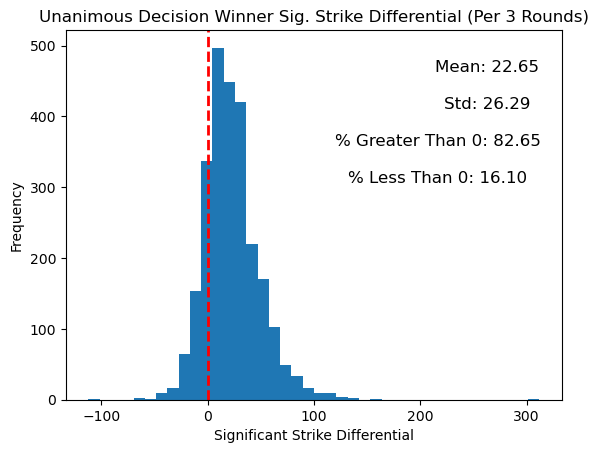

In [31]:
# Visualize Distribution of Winner Strike Differential in Unanimous Decision Fights

U_DEC = decision_data_1[decision_data_1["Method"] == "U-DEC"]
plt.hist(U_DEC["Diff_Str"], bins = 40)
mean_value = U_DEC["Diff_Str"].mean()
std_value = U_DEC["Diff_Str"].std()
greater_than_0 = (len(U_DEC[U_DEC["Diff_Str"] > 0])/len(U_DEC))*100
less_than_0 = (len(U_DEC[U_DEC["Diff_Str"] < 0])/len(U_DEC))*100
plt.text(0.85, 0.9, f'Mean: {mean_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.85, 0.8, f'Std: {std_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.75, 0.7, f'% Greater Than 0: {greater_than_0:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.75, 0.6, f'% Less Than 0: {less_than_0:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
plt.xlabel('Significant Strike Differential')
plt.ylabel('Frequency')
plt.title('Unanimous Decision Winner Sig. Strike Differential (Per 3 Rounds)')
plt.show()

The chart below shows the distribution of the winning fighter's takedown differential. The distribution is slightly right-skewed with a mean of 1.55 and standard deviation of 2.98. The chart suggests that winners of a unanimous decision are more likely to win the takedown battle, but, as with significant strikes, quite a few winning fighters lost the takedown battle.

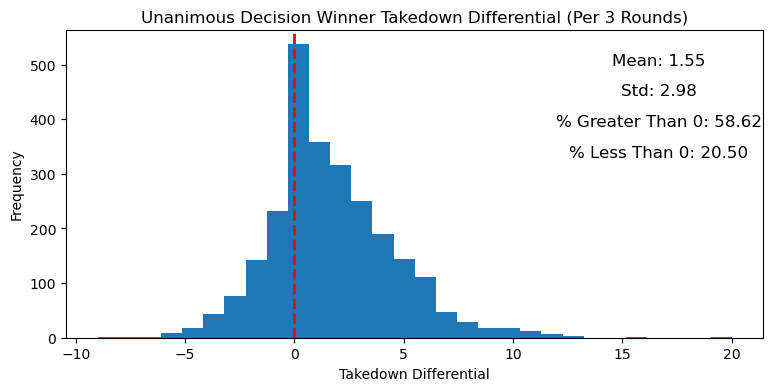

In [34]:
# Visualize Distribution of Winner Takedown Differential in Unanimous Decision Fights
plt.figure(figsize=(9,4))
plt.hist(U_DEC["Diff_Td"], bins = 30)
mean_value = U_DEC["Diff_Td"].mean()
std_value =  U_DEC["Diff_Td"].std()
greater_than_0 = (len(U_DEC[U_DEC["Diff_Td"] > 0])/len(U_DEC))*100
less_than_0 = (len(U_DEC[U_DEC["Diff_Td"] < 0])/len(U_DEC))*100
plt.text(0.85, 0.9, f'Mean: {mean_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.85, 0.8, f'Std: {std_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.85, 0.7, f'% Greater Than 0: {greater_than_0:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.85, 0.6, f'% Less Than 0: {less_than_0:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
plt.xlabel('Takedown Differential')
plt.ylabel('Frequency')
plt.title('Unanimous Decision Winner Takedown Differential (Per 3 Rounds)')
plt.show()

#### Split Decision Analysis

Split Decisions occur when one of the three judges scores the declared winner of the fight as the loser. As there is no consensus winner among the judges, these fights are inherently controversial. Thus, it is to be expected that the mean strike differential is to be smaller than those of a Unanimous Decision. The chart below bears this out. The distribution has little-to-no skew with a mean of 4.46 and 20.38 standard deviation. Additionally, many winners of split decisions actually lost the striking battle.

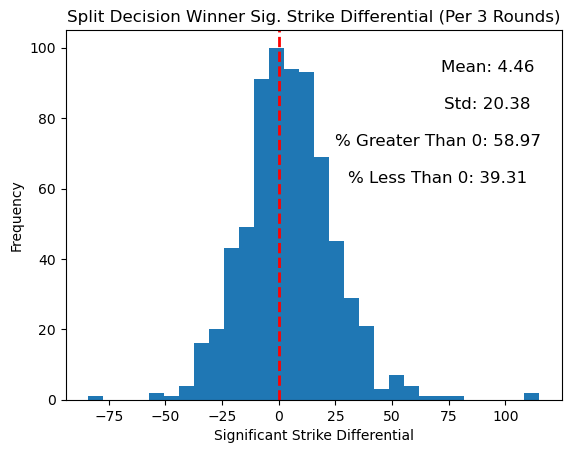

In [20]:
# Visualize Distribution of Winner Strike Differential in Split Decision Fights

S_DEC = decision_data_1[decision_data_1["Method"] == "S-DEC"]
plt.hist(S_DEC["Diff_Str"], bins = 30)
mean_value = S_DEC["Diff_Str"].mean()
std_value = S_DEC["Diff_Str"].std()
greater_than_0 = (len(S_DEC[S_DEC["Diff_Str"] > 0])/len(S_DEC))*100
less_than_0 = (len(S_DEC[S_DEC["Diff_Str"] < 0])/len(S_DEC))*100
plt.text(0.85, 0.9, f'Mean: {mean_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.85, 0.8, f'Std: {std_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.75, 0.7, f'% Greater Than 0: {greater_than_0:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.75, 0.6, f'% Less Than 0: {less_than_0:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
plt.xlabel("Significant Strike Differential")
plt.ylabel('Frequency')
plt.title('Split Decision Winner Sig. Strike Differential (Per 3 Rounds)')
plt.show()

In a similar fashion to the chart above, the distribution of the takedown differential has almost no skew. The mean is 0.23, and the standard deviation is 2.63. These two charts suggest that perhaps strike differential and takedown differential are not excellent predictors for the winner of a split decision. Perhaps more highly differentiated striking and takedown data can assist in painting a higher-resolution picture of these fights.

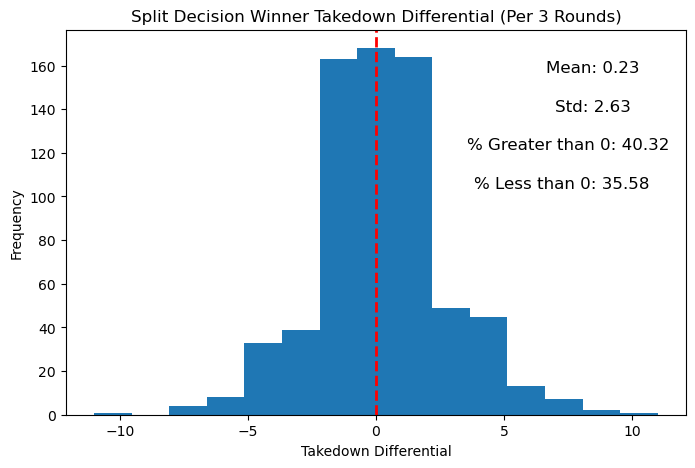

In [17]:
# Visualize Distribution of Winner Takedown Differential in Split Decision Fights
plt.figure(figsize=(8, 5))
plt.hist(S_DEC["Diff_Td"], bins = 15)
mean_value = S_DEC["Diff_Td"].mean()
std_value = S_DEC["Diff_Td"].std()
greater_than_0 = (len(S_DEC[S_DEC["Diff_Td"] > 0])/len(S_DEC))*100
less_than_0 = (len(S_DEC[S_DEC["Diff_Td"] < 0])/len(S_DEC))*100
plt.text(0.85, 0.9, f'Mean: {mean_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.85, 0.8, f'Std: {std_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.81, 0.7, f'% Greater than 0: {greater_than_0:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.8, 0.6, f'% Less than 0: {less_than_0:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
plt.xlabel('Takedown Differential')
plt.ylabel('Frequency')
plt.title('Split Decision Winner Takedown Differential (Per 3 Rounds)')
plt.show()

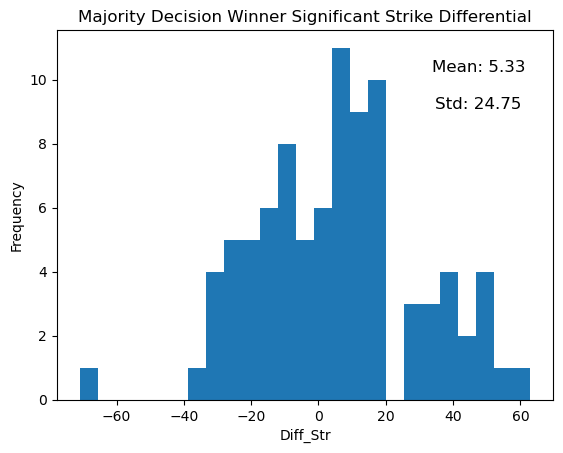

In [68]:
# Visualize Distribution of Winner Strike Differential in Split Decision Fights

M_DEC = decision_data_1[decision_data_1["Method"] == "M-DEC"]
plt.hist(M_DEC["Diff_Str"], bins = 25)
mean_value = M_DEC["Diff_Str"].mean()
std_value = M_DEC["Diff_Str"].std()
plt.text(0.85, 0.9, f'Mean: {mean_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.85, 0.8, f'Std: {std_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.xlabel('Diff_Str')
plt.ylabel('Frequency')
plt.title('Majority Decision Winner Significant Strike Differential')
plt.show()

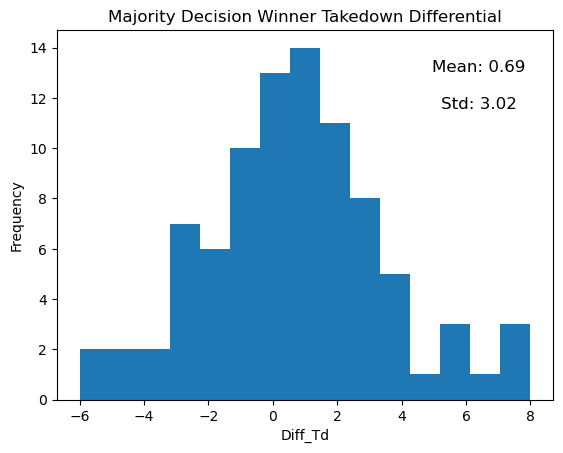

In [20]:
# Visualize Distribution of Winner Takedown Differential in Majority Decision Fights

plt.hist(M_DEC["Diff_Td"], bins = 15)
mean_value = M_DEC["Diff_Td"].mean()
std_value = M_DEC["Diff_Td"].std()
plt.text(0.85, 0.9, f'Mean: {mean_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.85, 0.8, f'Std: {std_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.xlabel('Diff_Td')
plt.ylabel('Frequency')
plt.title('Majority Decision Winner Takedown Differential')
plt.show()

An interesting question: How many winners were both outstruck and lost the takedown battle?

In [22]:
len(decision_data_1[(decision_data_1["Diff_Str"] < 0) & (decision_data_1["Diff_Td"] < 0)])

136

This number is very low, but questions do arise for our analysis. The charts above suggest that Takedowns and Significant Strikes are good predictors of victors in decisive victories, but in close fights, they are less helpful. Can the "second-level" statistics we have in the second dataset help paint a clearer picture?

# Model Selection

### General Model

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.tools import add_constant

In [56]:
data = pd.read_csv("model_data_1.csv")
data

,Unnamed: 0,Method,Diff_Kd,Diff_Str,Diff_Td,Diff_Sub,Diff_Head,Diff_Body,Diff_Leg,Diff_Distance,Diff_Clinch,Diff_Ground,Diff_Ctrl,Fighter_1_W
0,0,M-DEC,0,-2,-4,-1,0,3,-5,11,1,-14,-432,0
1,1,U-DEC,0,-18,-3,1,-4,-2,-12,-9,-4,-5,-286,0
2,2,U-DEC,0,7,1,0,10,8,-11,0,3,4,-218,0
3,3,U-DEC,0,2,-2,0,6,-4,0,12,-6,-4,-238,0
4,4,U-DEC,-1,-27,1,0,16,18,-7,23,11,-7,-262,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3298,3305,U-DEC,0,-15,0,0,1,14,0,2,0,13,856,1
3299,3306,U-DEC,0,2,2,2,-1,4,-5,0,-2,0,-388,1
3300,3307,U-DEC,0,-70,-5,1,43,27,0,8,0,62,0,1
3301,3310,S-DEC,0,2,6,-1,-9,5,2,4,1,-7,0,1


In [57]:
data = data.drop(data.columns[0], axis = 1)
data

,Method,Diff_Kd,Diff_Str,Diff_Td,Diff_Sub,Diff_Head,Diff_Body,Diff_Leg,Diff_Distance,Diff_Clinch,Diff_Ground,Diff_Ctrl,Fighter_1_W
0,M-DEC,0,-2,-4,-1,0,3,-5,11,1,-14,-432,0
1,U-DEC,0,-18,-3,1,-4,-2,-12,-9,-4,-5,-286,0
2,U-DEC,0,7,1,0,10,8,-11,0,3,4,-218,0
3,U-DEC,0,2,-2,0,6,-4,0,12,-6,-4,-238,0
4,U-DEC,-1,-27,1,0,16,18,-7,23,11,-7,-262,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3298,U-DEC,0,-15,0,0,1,14,0,2,0,13,856,1
3299,U-DEC,0,2,2,2,-1,4,-5,0,-2,0,-388,1
3300,U-DEC,0,-70,-5,1,43,27,0,8,0,62,0,1
3301,S-DEC,0,2,6,-1,-9,5,2,4,1,-7,0,1


In [58]:
import sklearn
from sklearn.model_selection import train_test_split

train, test = train_test_split(data,
                               test_size=0.4,
                               stratify=data["Method"],
                              random_state = 42)

In [59]:
train

,Method,Diff_Kd,Diff_Str,Diff_Td,Diff_Sub,Diff_Head,Diff_Body,Diff_Leg,Diff_Distance,Diff_Clinch,Diff_Ground,Diff_Ctrl,Fighter_1_W
2826,U-DEC,-1,9,0,0,-21,-5,17,17,-28,2,-209,1
1146,U-DEC,0,0,-2,0,9,-5,-4,9,-4,-5,-237,0
416,S-DEC,0,31,-1,0,-48,-4,21,-37,6,0,208,1
1967,U-DEC,0,-15,1,0,6,1,8,18,3,-6,-27,1
3282,U-DEC,0,-23,1,2,29,0,-6,7,13,3,26,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,U-DEC,0,-57,0,0,31,12,14,56,1,0,-13,1
2816,U-DEC,-2,-36,0,0,-12,-6,-18,-29,-4,-3,-11,0
2266,S-DEC,0,-22,-1,-4,3,9,10,22,5,-5,-325,1
2473,U-DEC,0,-71,1,0,30,46,-5,14,50,7,-69,1


In [60]:
X_train = train[["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Leg", 
                "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]]
y_train = train["Fighter_1_W"]
X_test = test[["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Leg", 
              "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]]
y_test = test["Fighter_1_W"]

In [61]:
X_train.head()

,Diff_Kd,Diff_Str,Diff_Td,Diff_Sub,Diff_Head,Diff_Leg,Diff_Clinch,Diff_Ground,Diff_Ctrl
2826,-1,9,0,0,-21,17,-28,2,-209
1146,0,0,-2,0,9,-4,-4,-5,-237
416,0,31,-1,0,-48,21,6,0,208
1967,0,-15,1,0,6,8,3,-6,-27
3282,0,-23,1,2,29,-6,13,3,26


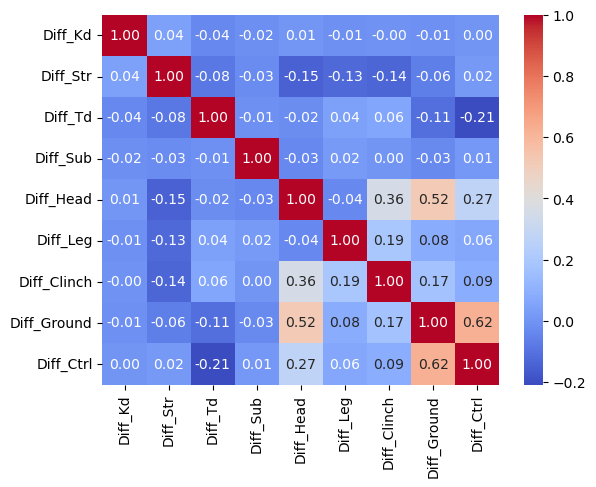

In [62]:
# Checking for Correlation Among Predictors
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [63]:
features = ["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Leg", 
         "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_with_intercept = add_constant(X_train_scaled)

logit_model = sm.Logit(y_train, X_train_with_intercept)
result = logit_model.fit()
print(result.summary(xname=["const"] + features))

Optimization terminated successfully.
         Current function value: 0.353045
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            Fighter_1_W   No. Observations:                 1981
Model:                          Logit   Df Residuals:                     1971
Method:                           MLE   Df Model:                            9
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                  0.4638
Time:                        21:51:41   Log-Likelihood:                -699.38
converged:                       True   LL-Null:                       -1304.3
Covariance Type:            nonrobust   LLR p-value:                8.781e-255
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9150      0.085     10.759      0.000       0.748       1.082
Diff_Kd         0.1308    

In [64]:
X_test_scaled = scaler.transform(X_test)  # Use the same scaler as on the training set
X_test_with_intercept = add_constant(X_test_scaled)

# Predict on the test set
y_pred = result.predict(X_test_with_intercept)

# Convert predicted probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = (y_pred_binary == y_test).mean()
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8419


In [111]:
print(conf_matrix)

[[390  93]
 [131 708]]


### Unanimous Decision Model

In [65]:
ud_data = data[data["Method"] == "U-DEC"]
ud_data

,Method,Diff_Kd,Diff_Str,Diff_Td,Diff_Sub,Diff_Head,Diff_Body,Diff_Leg,Diff_Distance,Diff_Clinch,Diff_Ground,Diff_Ctrl,Fighter_1_W
1,U-DEC,0,-18,-3,1,-4,-2,-12,-9,-4,-5,-286,0
2,U-DEC,0,7,1,0,10,8,-11,0,3,4,-218,0
3,U-DEC,0,2,-2,0,6,-4,0,12,-6,-4,-238,0
4,U-DEC,-1,-27,1,0,16,18,-7,23,11,-7,-262,1
5,U-DEC,0,-48,3,0,5,16,27,39,10,-1,-404,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3297,U-DEC,1,-2,-6,-1,5,-2,-1,-3,-1,6,990,1
3298,U-DEC,0,-15,0,0,1,14,0,2,0,13,856,1
3299,U-DEC,0,2,2,2,-1,4,-5,0,-2,0,-388,1
3300,U-DEC,0,-70,-5,1,43,27,0,8,0,62,0,1


In [66]:
train, test = train_test_split(ud_data,
                               test_size=0.4,
                               random_state = 42)

In [67]:
X_train = train[["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Leg", 
                "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]]
y_train = train["Fighter_1_W"]
X_test = test[["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Leg", 
                "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]]
y_test = test["Fighter_1_W"]

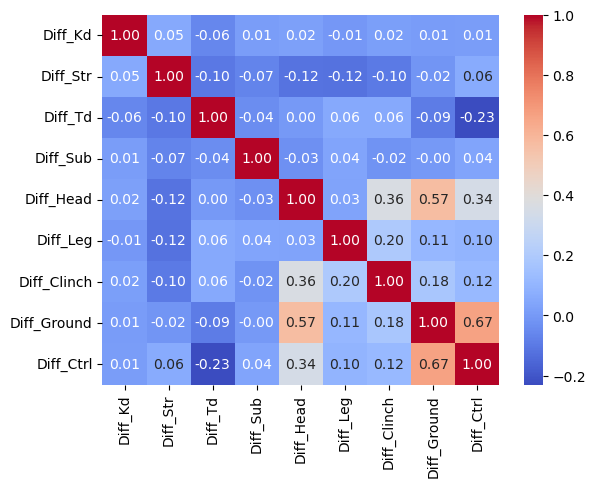

In [68]:
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [69]:
features = ["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Leg", 
         "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_with_intercept = add_constant(X_train_scaled)

logit_model = sm.Logit(y_train, X_train_with_intercept)
result = logit_model.fit()
print(result.summary(xname=["const"] + features))

Optimization terminated successfully.
         Current function value: 0.252946
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            Fighter_1_W   No. Observations:                 1524
Model:                          Logit   Df Residuals:                     1514
Method:                           MLE   Df Model:                            9
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                  0.6143
Time:                        21:51:52   Log-Likelihood:                -385.49
converged:                       True   LL-Null:                       -999.41
Covariance Type:            nonrobust   LLR p-value:                1.182e-258
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1696      0.132      8.842      0.000       0.910       1.429
Diff_Kd        -0.0455    

In [70]:
X_test_scaled = scaler.transform(X_test)  # Use the same scaler as on the training set
X_test_with_intercept = add_constant(X_test_scaled)

# Predict on the test set
y_pred = result.predict(X_test_with_intercept)

# Convert predicted probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = (y_pred_binary == y_test).mean()
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8927


### Split Decision Model

In [71]:
sd_data = data[data["Method"] == "S-DEC"]
sd_data

,Method,Diff_Kd,Diff_Str,Diff_Td,Diff_Sub,Diff_Head,Diff_Body,Diff_Leg,Diff_Distance,Diff_Clinch,Diff_Ground,Diff_Ctrl,Fighter_1_W
23,S-DEC,0,-9,-3,1,-28,-8,27,5,-1,-13,-237,0
24,S-DEC,-1,-4,3,0,-7,6,5,-16,25,-5,-358,1
25,S-DEC,0,22,0,0,13,-3,12,25,-3,0,0,0
39,S-DEC,0,-32,-1,0,5,-2,29,40,1,-9,-23,1
51,S-DEC,-1,19,-1,0,-26,6,1,-14,-7,2,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3252,S-DEC,0,-27,1,1,6,11,10,3,12,12,-93,1
3258,S-DEC,0,-3,1,1,25,9,-31,-10,3,10,-17,1
3261,S-DEC,0,-3,1,0,13,-9,-1,13,-10,0,19,1
3288,S-DEC,0,-33,4,0,11,19,3,3,36,-6,-166,1


In [72]:
train, test = train_test_split(sd_data,
                               test_size=0.4,
                               random_state = 42)

In [73]:
X_train = train[["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Leg", 
               "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]]
y_train = train["Fighter_1_W"]
X_test = test[["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Leg", 
               "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]]
y_test = test["Fighter_1_W"]

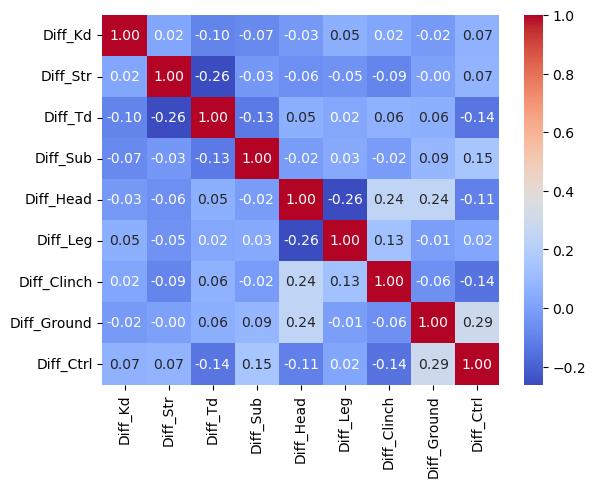

In [74]:
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [75]:
features = ["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Leg", 
            "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_with_intercept = add_constant(X_train_scaled)

logit_model = sm.Logit(y_train, X_train_with_intercept)
result = logit_model.fit()
print(result.summary(xname=["const"] + features))

Optimization terminated successfully.
         Current function value: 0.622147
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Fighter_1_W   No. Observations:                  409
Model:                          Logit   Df Residuals:                      399
Method:                           MLE   Df Model:                            9
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                 0.09139
Time:                        21:52:05   Log-Likelihood:                -254.46
converged:                       True   LL-Null:                       -280.05
Covariance Type:            nonrobust   LLR p-value:                 6.428e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2898      0.107      2.714      0.007       0.081       0.499
Diff_Kd         0.1141    

In [76]:
X_test_scaled = scaler.transform(X_test)  # Use the same scaler as on the training set
X_test_with_intercept = add_constant(X_test_scaled)

# Predict on the test set
y_pred = result.predict(X_test_with_intercept)

# Convert predicted probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = (y_pred_binary == y_test).mean()
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6703


In [113]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [48]:
dt = DecisionTreeClassifier(random_state=43)

params = {'criterion':['gini','entropy'],
          'max_depth':[3,5,7,10],
          'min_samples_leaf':[3,5,10,15],
          'min_samples_split':[8,10,12,18]
          }
RS = RandomizedSearchCV(estimator=dt,param_distributions=params,cv=5,n_iter=300, scoring='accuracy')

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy: 0.9470499243570348


As seen above, none of the predictors are significant in our model. Perhaps adding the striking data will be more useful down the line.